![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/3.Clinical_Entity_Resolvers.ipynb)

**Setup**

In [ ]:
import sys
import json
import os
with open('license.json') as f:
    license_keys = json.load(f)
    
import os
locals().update(license_keys)
os.environ.update(license_keys)

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.1.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

In [3]:
import json
import os

import sparknlp
import sparknlp_jsl

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *

import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline,PipelineModel

import warnings
warnings.filterwarnings('ignore')

params = {"spark.driver.memory":"16G", 
          "spark.kryoserializer.buffer.max":"2000M", 
          "spark.driver.maxResultSize":"2000M"} 

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

print("Spark NLP Version :", sparknlp.version())
print("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark

Spark NLP Version : 3.4.2
Spark NLP_JSL Version : 3.5.0


# Sentence Entity Resolver Models


A common NLP problem in biomedical aplications is to identify the presence of clinical entities in a given text. This clinical entities could be diseases, symptoms, drugs, results of clinical investigations or others.

To convert a sentence or document into a vector for semantic search or to build a recommendation system, one of the most popularly advised approaches is to pass the text through a transformer model like BERT, etc, and collect the embedding vector of CLS token or average out the embeddings of the tokens from the last layer to get a single vector.

Truth be told, this approach of finding similar documents through embedding the CLS token or average embedding of the last layer performs much worse than averaging of word2vec/Glove embedding to form a sentence/document vector.
On top of that, word2vec/Glove averaging is very fast to run when compared to extracting a vector through the transformer model.

A better approach for transformer-based embedding is to use fine-tuned Siamese network variants (SBERT etc) that are trained to embed similar sentences/ documents to a closer embedding space and separate the non-similar ones. That’s what we are doing here at Sentence Resolvers and it is why we outperform Chunk Resolvers.

Otherwise, the raw embedding vectors (CLS, etc) from the last layers of these transformer models don't yield any superior results for similarity search when compared to avg word2vec/Glove embeddings.

<img src="https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/data/Entity%20Resolution%20in%20Spark%20NLP%20for%20Healthcare.jpeg?raw=true" width="1000" alt="RxNorm Overview">

Other than providing the code in the "result" field it provides more metadata about the matching process:

- target_text -> Text to resolve
- resolved_text -> Best match text
- confidence -> Relative confidence for the top match (distance to probability)
- confidence_ratio -> Relative confidence for the top match. TopMatchConfidence / SecondMatchConfidence
- alternative_codes -> List of other plausible codes (in the KNN neighborhood)
- all_k_resolutions -> All codes descriptions
- all_k_results -> All resolved codes for metrics calculation purposes
- sentence -> SentenceId

We create a new pipeline that from each of these problems will try to assign an resolution on the content, the sentence embeddings and some pretrained models for resolver annotation.

The architecture of this new pipeline will be as follows:

- DocumentAssembler (text -> document)

- SentenceDetector (document -> sentence)

- Tokenizer (sentence -> token)

- WordEmbeddingsModel ([sentence, token] -> embeddings)

- MedicalNerModel ([sentence, token, embeddings] -> ner)

- NerConverter (["sentence, token, ner] -> ner_chunk

- Chunk2Doc (ner_chunk) -> ner_chunk_doc

- BertSentenceEmbeddings (ner_chunk_doc) -> sbert_embeddings

- SentenceEntityResolverModel ([ner_chunk, sbert_embeddings] -> resolution)

So from a text we end having a list of Named Entities (ner_chunk) and their resolutions.

`setPreservePosition(True)` takes exactly the original indices (under some tokenization conditions it might include some undesires chars like `")","]"...)`

`setPreservePosition(False)` takes adjusted indices based on substring indexing of the first (for begin) and last (for end) tokens


| index | model                                                                                                                                                               |   index | model                                                                                                                                             |   index | model                                                                                                                           |   index | model                                                                                                                                             |
|------:|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------:|:--------------------------------------------------------------------------------------------------------------------------------------------------|--------:|:--------------------------------------------------------------------------------------------------------------------------------|--------:|:--------------------------------------------------------------------------------------------------------------------------------------------------|
|     1 | [sbertresolve_icd10cm_slim_billable_hcc_med](https://nlp.johnsnowlabs.com/2021/08/26/sbertresolve_icd10cm_slim_billable_hcc_med_en.html),                           |      15 | [sbiobertresolve_hcc_augmented](https://nlp.johnsnowlabs.com/2021/05/30/sbiobertresolve_hcc_augmented_en.html),                                   |      29 | [sbiobertresolve_icdo_base](https://nlp.johnsnowlabs.com/2021/07/02/sbiobertresolve_icdo_base_en.html),                         |      43 | [sbiobertresolve_snomed_auxConcepts_int](https://nlp.johnsnowlabs.com/2021/05/16/sbiobertresolve_snomed_auxConcepts_int_en.html)',                |
|     2 | [sbertresolve_ner_model_finder](https://nlp.johnsnowlabs.com/2021/11/24/sbertresolve_ner_model_finder_en.html),                                                     |      16 | [sbiobertresolve_hcpcs](https://nlp.johnsnowlabs.com/2021/09/29/sbiobertresolve_hcpcs_en.html),                                                   |      30 | [sbiobertresolve_loinc](https://nlp.johnsnowlabs.com/2021/05/16/sbiobertresolve_loinc_en.html),                                 |      44 | [sbiobertresolve_snomed_bodyStructure](https://nlp.johnsnowlabs.com/2021/07/08/sbiobertresolve_snomed_bodyStructure_en.html),                     |
|     3 | [sbiobertresolve_rxnorm](https://nlp.johnsnowlabs.com/2021/10/10/sbiobertresolve_rxnorm_en.html)                                                                    |      17 | [sbiobertresolve_icd10cm](https://nlp.johnsnowlabs.com/2021/10/31/sbiobertresolve_icd10cm_augmented_en.html),                                     |      31 | [sbiobertresolve_loinc_augmented](https://nlp.johnsnowlabs.com/2021/11/23/sbiobertresolve_loinc_augmented_en.html) ,            |      45 | [sbiobertresolve_snomed_findings](https://nlp.johnsnowlabs.com/2021/06/15/sbiobertresolve_snomed_findings_en.html),                               |
|     4 | [sbertresolve_snomed_bodyStructure_med](https://nlp.johnsnowlabs.com/2021/07/08/sbertresolve_snomed_bodyStructure_med_en.html),                                     |      18 | [sbiobertresolve_icd10cm_augmented](https://nlp.johnsnowlabs.com/2021/10/31/sbiobertresolve_icd10cm_augmented_en.html),                           |      32 | [sbiobertresolve_mesh](https://nlp.johnsnowlabs.com/2021/11/14/sbiobertresolve_mesh_en.html),                                   |      46 | [sbiobertresolve_snomed_findings_aux_concepts](https://nlp.johnsnowlabs.com/2021/07/14/sbiobertresolve_snomed_findings_aux_concepts_en.html),     |
|     5 | [sbertresolve_snomed_conditions](https://nlp.johnsnowlabs.com/2021/08/28/sbertresolve_snomed_conditions_en.html),                                                   |      19 | [sbiobertresolve_icd10cm_augmented_billable_hcc](https://nlp.johnsnowlabs.com/2021/11/01/sbiobertresolve_icd10cm_augmented_billable_hcc_en.html), |      33 | [sbiobertresolve_ndc](https://nlp.johnsnowlabs.com/2021/11/27/sbiobertresolve_ndc_en.html),                                     |      47 | [sbiobertresolve_snomed_findings_int](https://nlp.johnsnowlabs.com/2021/05/16/sbiobertresolve_snomed_findings_int_en.html),                       |
|     6 | [sbiobertresolve_HPO](https://nlp.johnsnowlabs.com/2021/05/16/sbiobertresolve_HPO_en.html),                                                                         |      20 | [sbiobertresolve_icd10cm_generalised](https://nlp.johnsnowlabs.com/2021/09/29/sbiobertresolve_icd10cm_generalised_en.html),                       |      34 | [sbiobertresolve_rxcui](https://nlp.johnsnowlabs.com/2020/12/11/sbiobertresolve_rxcui_en.html),                                 |      48 | [sbiobertresolve_snomed_procedures_measurements](https://nlp.johnsnowlabs.com/2021/11/11/sbiobertresolve_snomed_procedures_measurements_en.html), |
|     7 | [sbiobertresolve_clinical_snomed_procedures_measurements](https://nlp.johnsnowlabs.com/2021/11/15/sbiobertresolve_clinical_snomed_procedures_measurements_en.html), |      21 | [sbiobertresolve_icd10cm_slim_billable_hcc](https://nlp.johnsnowlabs.com/2021/08/26/sbiobertresolve_icd10cm_slim_billable_hcc_en.html),           |      35 | [sbiobertresolve_rxnorm_augmented_re](https://nlp.johnsnowlabs.com/2022/02/09/sbiobertresolve_rxnorm_augmented_re_en.html)      |      49 | [sbiobertresolve_umls_clinical_drugs](https://nlp.johnsnowlabs.com/2021/10/11/sbiobertresolve_umls_clinical_drugs_en.html),                       |
|     8 | [sbiobertresolve_cpt](https://nlp.johnsnowlabs.com/2021/05/16/sbiobertresolve_cpt_en.html),                                                                         |      22 | [sbiobertresolve_icd10cm_slim_normalized](https://nlp.johnsnowlabs.com/2021/05/17/sbiobertresolve_icd10cm_slim_normalized_en.html),               |      36 | [sbiobertresolve_rxnorm_augmented](https://nlp.johnsnowlabs.com/2021/11/04/sbiobertresolve_rxnorm_augmented_en.html),           |      50 | [sbiobertresolve_umls_disease_syndrome](https://nlp.johnsnowlabs.com/2021/10/11/sbiobertresolve_umls_disease_syndrome_en.html),                   |
|     9 | [sbiobertresolve_cpt_augmented](https://nlp.johnsnowlabs.com/2021/05/30/sbiobertresolve_cpt_augmented_en.html),                                                     |      23 | [sbiobertresolve_icd10pcs](https://nlp.johnsnowlabs.com/2021/05/16/sbiobertresolve_icd10pcs_en.html) ,                                            |      37 | [sbiobertresolve_rxnorm_disposition](https://nlp.johnsnowlabs.com/2021/08/12/sbiobertresolve_rxnorm_disposition_en.html),       |      51 | [sbiobertresolve_umls_findings](https://nlp.johnsnowlabs.com/2021/10/03/sbiobertresolve_umls_findings_en.html),                                   |
|    10 | [sbiobertresolve_cpt_procedures_augmented](https://nlp.johnsnowlabs.com/2021/06/15/sbiobertresolve_cpt_procedures_augmented_en.html),                               |      24 | [sbiobertresolve_icdo](https://nlp.johnsnowlabs.com/2021/05/16/sbiobertresolve_icdo_en.html),                                                     |      38 | [sbiobertresolve_rxnorm_ndc](https://nlp.johnsnowlabs.com/2021/10/05/sbiobertresolve_rxnorm_ndc_en.html),                       |      52 | [sbiobertresolve_umls_major_concepts](https://nlp.johnsnowlabs.com/2021/10/03/sbiobertresolve_umls_major_concepts_en.html),                       |
|    11 | [sbiobertresolve_cpt_procedures_measurements_augmented](https://nlp.johnsnowlabs.com/2021/07/02/sbiobertresolve_cpt_procedures_measurements_augmented_en.html),     |      25 | [sbiobertresolve_icdo_augmented](https://nlp.johnsnowlabs.com/2021/06/22/sbiobertresolve_icdo_augmented_en.html),                                 |      39 | [sbiobertresolve_snomed_auxConcepts](https://nlp.johnsnowlabs.com/2020/11/27/sbiobertresolve_snomed_auxConcepts_en.html),       |      53 | [sbluebertresolve_loinc](https://nlp.johnsnowlabs.com/2021/04/29/sbluebertresolve_loinc_en.html)                                                  |
|    12 | [sbiobertresolve_clinical_abbreviation_acronym](https://nlp.johnsnowlabs.com/2022/01/03/sbiobertresolve_clinical_abbreviation_acronym_en.html)                      |      26 | [sbiobertresolve_umls_drug_substance](https://nlp.johnsnowlabs.com/2021/12/06/sbiobertresolve_umls_drug_substance_en.html)                        |      40 | [sbluebertresolve_rxnorm_augmented_uncased](https://nlp.johnsnowlabs.com/2021/12/28/sbluebertresolve_rxnorm_augmented_uncased_en.html),|      54 | [sbiobertresolve_loinc_cased](https://nlp.johnsnowlabs.com/2021/12/24/sbiobertresolve_loinc_cased_en.html)                           |
|    13 | [sbluebert_base_uncased_mli](https://nlp.johnsnowlabs.com/2021/12/31/sbluebertresolve_loinc_uncased_en.html),                                                       |      27 | [sbiobertresolve_snomed_drug](https://nlp.johnsnowlabs.com/2022/01/01/sbiobertresolve_snomed_drug_en.html) ,                                      |      41 | [sbertresolve_jsl_rxnorm_augmented_med](https://nlp.johnsnowlabs.com/2021/12/28/sbertresolve_jsl_rxnorm_augmented_med_en.html)  |      55 | [sbiobertresolve_rxnorm_augmented_cased](https://nlp.johnsnowlabs.com/2021/12/28/sbiobertresolve_rxnorm_augmented_cased_en.html)            |
|    14 | [sbiobert_jsl_rxnorm_cased](https://nlp.johnsnowlabs.com/2021/12/23/sbiobert_jsl_rxnorm_cased_en.html),                                                       |      28 | [sbertresolve_rxnorm_disposition](https://nlp.johnsnowlabs.com/2021/08/28/sbertresolve_rxnorm_disposition_en.html) ,                                      |      42 | [sbiobertresolve_atc](https://nlp.johnsnowlabs.com/2022/03/01/sbiobertresolve_atc_en_3_0.html)  |      56 | [sbiobertresolve_jsl_rxnorm_augmented](https://nlp.johnsnowlabs.com/2021/12/27/sbiobertresolve_jsl_rxnorm_augmented_en.html)            |

### Helper Functions
Writing Generic Function For Getting the Codes and Relation Pairs

In [4]:
# returns LP resolution results

import pandas as pd
pd.set_option('display.max_colwidth', 0)


def get_codes (lp, text, vocab='icd10cm_code', hcc=False):
    
    full_light_result = lp.fullAnnotate(text)

    chunks = []
    codes = []
    begin = []
    end = []
    resolutions=[]
    all_distances =[]
    all_codes=[]
    all_cosines = []
    all_k_aux_labels=[]

    for chunk, code in zip(full_light_result[0]['ner_chunk'], full_light_result[0][vocab]):
            
        begin.append(chunk.begin)
        end.append(chunk.end)
        chunks.append(chunk.result)
        codes.append(code.result) 
        all_codes.append(code.metadata['all_k_results'].split(':::'))
        resolutions.append(code.metadata['all_k_resolutions'].split(':::'))
        all_distances.append(code.metadata['all_k_distances'].split(':::'))
        all_cosines.append(code.metadata['all_k_cosine_distances'].split(':::'))
        if hcc:
            try:
                all_k_aux_labels.append(code.metadata['all_k_aux_labels'].split(':::'))
            except:
                all_k_aux_labels.append([])
        else:
            all_k_aux_labels.append([])

    df = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end, 'code':codes, 'all_codes':all_codes, 
                       'resolutions':resolutions, 'all_k_aux_labels':all_k_aux_labels,'all_distances':all_cosines})
    
    if hcc:

        df['billable'] = df['all_k_aux_labels'].apply(lambda x: [i.split('||')[0] for i in x])
        df['hcc_status'] = df['all_k_aux_labels'].apply(lambda x: [i.split('||')[1] for i in x])
        df['hcc_code'] = df['all_k_aux_labels'].apply(lambda x: [i.split('||')[2] for i in x])

    df = df.drop(['all_k_aux_labels'], axis=1)
    
    return df



In [5]:
# returns spark df resolution results

def get_codes_from_df(result_df, chunk, output_col, hcc= False):
    
    
    if hcc:
        
        df = result_df.select(F.explode(F.arrays_zip(chunk+'.result', 
                                                           chunk+'.metadata', 
                                                           output_col+'.result', 
                                                           output_col+'.metadata')).alias("cols")) \
                                     .select(F.expr("cols['1']['sentence']").alias("sent_id"),
                                             F.expr("cols['0']").alias("ner_chunk"),
                                             F.expr("cols['1']['entity']").alias("entity"), 
                                             F.expr("cols['2']").alias("icd10_code"),
                                             F.expr("cols['3']['all_k_results']").alias("all_codes"),
                                             F.expr("cols['3']['all_k_resolutions']").alias("resolutions"),
                                             F.expr("cols['3']['all_k_aux_labels']").alias("hcc_list")).toPandas()



        codes = []
        resolutions = []
        hcc_all = []

        for code, resolution, hcc in zip(df['all_codes'], df['resolutions'], df['hcc_list']):

            codes.append(code.split(':::'))
            resolutions.append(resolution.split(':::'))
            hcc_all.append(hcc.split(":::"))

        df['all_codes'] = codes  
        df['resolutions'] = resolutions
        df['hcc_list'] = hcc_all
        
    else:
                       
        df = result_df.select(F.explode(F.arrays_zip(chunk+'.result', 
                                                           chunk+'.metadata', 
                                                           output_col+'.result', 
                                                           output_col+'.metadata')).alias("cols")) \
                                     .select(F.expr("cols['1']['sentence']").alias("sent_id"),
                                             F.expr("cols['0']").alias("ner_chunk"),
                                             F.expr("cols['1']['entity']").alias("entity"), 
                                             F.expr("cols['2']").alias(f"{output_col}"),
                                             F.expr("cols['3']['all_k_results']").alias("all_codes"),
                                             F.expr("cols['3']['all_k_resolutions']").alias("resolutions")).toPandas()



        codes = []
        resolutions = []

        for code, resolution in zip(df['all_codes'], df['resolutions']):

            codes.append(code.split(':::'))
            resolutions.append(resolution.split(':::'))

        df['all_codes'] = codes  
        df['resolutions'] = resolutions
        
    
    return df

In [6]:
# returns billable informations in distinct columns

def extract_billable(bil):
  
    billable = []
    status = []
    code = []
 
    for b in bil:
        billable.append(b.split("||")[0])
        status.append(b.split("||")[1])
        code.append(b.split("||")[2])

    return (billable, status, code)

In [7]:
# returns relation pair dataframe

def get_relations_df (results, col='relations'):
    rel_pairs=[]
    for rel in results[0][col]:
        rel_pairs.append(( 
          rel.metadata['entity1'], 
          rel.metadata['entity1_begin'],
          rel.metadata['entity1_end'],
          rel.metadata['chunk1'], 
          rel.metadata['entity2'],
          rel.metadata['entity2_begin'],
          rel.metadata['entity2_end'],
          rel.metadata['chunk2'], 
          rel.metadata['confidence']
        ))

    rel_df = pd.DataFrame(rel_pairs, columns=['entity1','entity1_begin','entity1_end','chunk1',
                                              'entity2','entity2_end','entity2_end','chunk2', 
                                              'confidence'])
    
    # limit df columns to get entity and chunks with results only
    rel_df = rel_df.iloc[:,[0,3,4,7,8]]
    
    return rel_df

## Sentence Entity Resolver (RxNorm)

- RxNorm is a second vocabulary for prescription drugs. RxNorm provides a set of codes for clinical drugs, which are the combination of active ingredients, dose form, and strength of a drug. For example, the RxNorm code for ciprofloxacin 500 mg 24-hour extended-release tablet (the generic name for Cipro XR 500 mg) is RX10359383, regardless of brand or packaging.

- The goal of RxNorm is to allow computer systems to communicate drug-related information efficiently and unambiguously. Produced by the National Library of Medicine (NLM), RxNorm is available for distribution in both Metathesaurus Relation (MR) and Rich Release Format (RRF) tables. Currently there are no RxNorm names available for drugs with more than four active ingredients, those that are sold over the counter (OTC) or those that are international, due to the lack of appropriate information available about such drugs. 


<img src="https://www.nlm.nih.gov/research/umls/rxnorm/RxNorm_Drug_Relationships.png" width="750" alt="RxNorm Overview">

**Pretrained Models**

- `sbiobertresolve_rxnorm`
- `demo_sbiobertresolve_rxnorm`
- `sbiobertresolve_rxnorm_dispo`
- `sbiobertresolve_rxnorm_disposition`
- `sbertresolve_rxnorm_disposition`
- `sbiobertresolve_rxnorm_ndc`
- `sbiobertresolve_rxnorm_augmented`
- `sbiobertresolve_rxnorm_augmented_re`

In [8]:
documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("ner_chunk")

sbert_embedder = BertSentenceEmbeddings.pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
      .setInputCols(["ner_chunk"])\
      .setOutputCol("sentence_embeddings")\
      .setCaseSensitive(False)
    
rxnorm_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_rxnorm_augmented","en", "clinical/models") \
      .setInputCols(["ner_chunk", "sentence_embeddings"]) \
      .setOutputCol("rxnorm_code")\
      .setDistanceFunction("EUCLIDEAN")

rxnorm_pipelineModel = PipelineModel(
      stages = [
          documentAssembler,
          sbert_embedder,
          rxnorm_resolver])

rxnorm_lp = LightPipeline(rxnorm_pipelineModel)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_rxnorm_augmented download started this may take some time.
Approximate size to download 930.9 MB
[OK!]


In [9]:
text = 'metformin 100 mg'

%time get_codes (rxnorm_lp, text, vocab='rxnorm_code')

CPU times: user 35.6 ms, sys: 7.32 ms, total: 42.9 ms
Wall time: 4.98 s


chunks  begin  end     code  \
0  metformin 100 mg  0      15   2200518   

                                                                                                                                                                     all_codes  \
0  [2200518, 861024, 141916, 334738, 332848, 104494, 199955, 333262, 439563, 429178, 103910, 429408, 450523, 1744000, 401938, 402346, 1726496, 485246, 198758, 316350, 213092]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   resolutions  \
0  [metformin hydrochloride 100 MG/ML Extended Release Suspension, metformin hydrochloride 100 MG/ML, fenofibrate 100 MG Oral Capsule, fenofibrate 100 MG, ciprofibrate 100 MG, ciprofibrate 100 MG Oral Tablet, rutin 100 MG Oral Tablet, rutin 100 MG, fendiline 100 MG, fendiline 100 MG Oral Tablet, carbamazepine 100 MG Oral Tablet [Epimaz], perazine 100 MG Oral Tablet, perazine 100 MG, emtricitabine 100 MG, miglustat 100 MG Oral Capsule, miglustat 100 MG, azacitidine 100 MG, azacitidine 100 MG Injection, niacin 100 MG Oral Capsule, niacin 100 MG, dolasetron 100 MG Oral Tablet [Anzemet]]   

                                                                                                                                                              all_distances  
0  [0.0658, 0.0658, 0.0684, 0.0684, 0.0697, 0.0697, 0.0765, 0.0765, 0.0775, 0.0775, 0.0780, 0.0804, 0.0804, 0.0818, 0.0811, 0.0811, 0.0812, 0.0812, 0.0811, 0.0811, 0.0836]

In [10]:
text = 'aspirin 10 meq/ 5 ml oral sol'

%time get_codes (rxnorm_lp, text, vocab='rxnorm_code')

CPU times: user 9.2 ms, sys: 5.36 ms, total: 14.6 ms
Wall time: 863 ms


chunks  begin  end    code  \
0  aspirin 10 meq/ 5 ml oral sol  0      28   996740   

                                                                                                                                                                     all_codes  \
0  [996740, 991082, 997398, 636574, 794979, 995241, 422031, 312036, 205247, 251102, 208820, 1117402, 246529, 544468, 1313296, 2536066, 892589, 755941, 104231, 201656, 251830]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        resolutions  \
0  [memantine hydrochloride 2 MG/ML Oral Solution, dicyclomine hydrochloride 2 MG/ML Oral Solution, codeine phosphate 2 MG/ML Oral Solution, guaifenesin 10 MG/ML Oral Solution, prednisolone 2 MG/ML Oral Solution, hydroxyzine hydrochloride 2 MG/ML Oral Solution, silymarin 10 MG/ML Oral Suspension, nortriptyline 2 MG/ML Oral Solution, niacin 10 MG/ML Oral Solution, nimesulide 10 MG/ML Oral Suspension, trifluoperazine 10 MG/ML Oral Solution [Stelazine], guaifenesin 10 MG/ML Oral Solution [Liqufruta], midodrine 10 MG/ML Oral Solution, hypromellose 10 MG/ML Oral Solution, guaifenesin 10 MG/ML / hydrocodone bitartrate 0.5 MG/ML / phenylephrine hydrochloride 1.5 MG/ML Oral Solution [Quala HC], ezetimibe 10 MG / rosuvastatin 5 MG Oral Tablet [Roszet], morphine sulfate 2 MG/ML Oral Solution, teferrol 10 MG/ML Oral Solution, spironolactone 2 MG/ML Oral Suspension, promazine 10 MG/ML Oral Suspension [Sparine], mebeverine 10 MG/ML Oral Solution]   

                                                                                                                                                              all_distances  
0  [0.0859, 0.0919, 0.0891, 0.0927, 0.0922, 0.0925, 0.0932, 0.0971, 0.0960, 0.0970, 0.0976, 0.0963, 0.0980, 0.1010, 0.0987, 0.0987, 0.0989, 0.0989, 0.1012, 0.0981, 0.1004]

### RxNorm with DrugNormalizer

In [11]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk_v0")

drug_normalizer = DrugNormalizer() \
    .setInputCols("ner_chunk_v0") \
    .setOutputCol("ner_chunk") \
    .setPolicy('all')

rxnorm_pipelineModel2 = PipelineModel(
    stages = [
        documentAssembler,
        drug_normalizer,
        sbert_embedder,
        rxnorm_resolver])

rxnorm_lp2 = LightPipeline(rxnorm_pipelineModel2)

In [12]:
text = 'aspirin 10 meq/ 5 ml oral sol'

%time get_codes (rxnorm_lp2, text, vocab='rxnorm_code')

CPU times: user 14.3 ms, sys: 3.65 ms, total: 18 ms
Wall time: 918 ms


chunks  begin  end    code  \
0  aspirin 2 meq/ml oral solution  0      29   688214   

                                                                                                                                                                                               all_codes  \
0  [688214, 342917, 688213, 755937, 756028, 979446, 755332, 545588, 1091135, 246229, 104692, 755920, 261342, 756064, 756078, 2381144, 1115998, 1092456, 248847, 1094188, 250944, 108870, 995243, 421803]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               resolutions  \
0  [aspirin 2.5 MG/ML Oral Solution, aspirin 2.2 MG/ML, aspirin 2.5 MG/ML, periciazine 2 MG/ML Oral Solution, fenspiride 2 MG/ML Oral Solution, metaproterenol sulfate 2 MG/ML Oral Solution [Alupent], dicyclomine hydrochloride 2 MG/ML Oral Solution [Merbentyl], racepinephrine 2 MG/ML Oral Solution [Orostat], methylphenidate hydrochloride 2 MG/ML Oral Solution [Methylin], thioridazine 2 MG/ML Oral Solution, temazepam 2 MG/ML Oral Solution [Euhypnos], butamirate 2 MG/ML Oral Solution, citalopram 2 MG/ML Oral Solution [Celexa], oxeladin 2 MG/ML Oral Solution, pipazethate 2 MG/ML Oral Solution, fenfluramine 2.2 MG/ML Oral Solution [Fintepla], ephedrine sulfate 2.2 MG/ML Oral Solution, diphenhydramine hydrochloride 2.5 MG/ML Oral Solution [Diphenhist], homatropine 2 MG/ML Oral Solution, diphenhydramine hydrochloride 2.5 MG/ML Oral Solution [Diphedryl], piracetam 2 MG/ML Oral Solution, theophylline 2 MG/ML Oral Solution, hydroxyzine hydrochloride 2 MG/ML Oral Solution [Atarax], codeine 2 MG/ML Oral Suspension]   

                                                                                                                                                                                      all_distances  
0  [0.0347, 0.0566, 0.0748, 0.0947, 0.1040, 0.1009, 0.1075, 0.1081, 0.1097, 0.1155, 0.1137, 0.1149, 0.1123, 0.1154, 0.1178, 0.1175, 0.1196, 0.1212, 0.1211, 0.1242, 0.1196, 0.1236, 0.1214, 0.1175]

### Drug Spell Checker

In [13]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

tokenizer = Tokenizer()\
    .setInputCols("document")\
    .setOutputCol("token")

spell = NorvigSweetingModel.pretrained("spellcheck_drug_norvig", "en", "clinical/models")\
    .setInputCols("token")\
    .setOutputCol("corrected_token")\

pipeline = Pipeline(stages = [documentAssembler,
                              tokenizer, 
                              spell])

model = pipeline.fit(spark.createDataFrame([['']]).toDF('text')) 

lp = LightPipeline(model)

corrected = lp.annotate("You have to take Neutrcare and colfosinum and a bit of Fluorometholne & Ribotril")

spellcheck_drug_norvig download started this may take some time.
Approximate size to download 3.7 MB
[OK!]


In [14]:
print(" ".join(corrected['token']))
print(" ".join(corrected['corrected_token']))

You have to take Neutrcare and colfosinum and a bit of Fluorometholne & Ribotril
You have to take Neutracare and colforsinum and a bit of Fluorometholone & Rivotril


## Sentence Entity Resolver (ICD-10CM)

###  ICD10 background info

**ICD-10-CM vs. ICD-10-PCS**

- With the transition to ICD-10, in the United States, ICD-9 codes are segmented into ICD-10-CM and ICD-10-PCS codes. **The "CM" in ICD-10-CM codes stands for clinical modification**; ICD-10-CM codes were developed by the Centers for Disease Control and Prevention in conjunction with the National Center for Health Statistics (NCHS), for outpatient medical coding and reporting in the United States, as published by the World Health Organization (WHO).

- **The "PCS" in ICD-10-PCS codes stands for the procedural classification system**. ICD-10-PCS is a completely separate medical coding system from ICD-10-CM, containing an additional 87,000 codes for use ONLY in United States inpatient, hospital settings. The procedure classification system (ICD-10-PCS) was developed by the Centers for Medicare and Medicaid Services (CMS) in conjunction with 3M Health Information Management (HIM).

- ICD-10-CM codes add increased specificity to their ICD-9 predecessors, growing to five times the number of codes as the present system; a total of 68,000 clinical modification diagnosis codes. ICD-10-CM codes provide the ability to track and reveal more information about the quality of healthcare, allowing healthcare providers to better understand medical complications, better design treatment and care, and better comprehend and determine the outcome of care.

- ICD-10-PCS is used only for inpatient, hospital settings in the United States, and is meant to replace volume 3 of ICD-9 for facility reporting of inpatient procedures. Due to the rapid and constant state of flux in medical procedures and technology, ICD-10-PCS was developed to accommodate the changing landscape. Common procedures, lab tests, and educational sessions that are not unique to the inpatient, hospital setting have been omitted from ICD-10-PCS.

- ICD-10 is confusing enough when you’re trying to digest the differences between ICD-9 and ICD-10, but there are also different types of ICD-10 codes that providers should be aware of.


**Primary difference between ICD-10-CM and ICD-10-PCS**

- When most people talk about ICD-10, they are referring to ICD-10CM. This is the code set for diagnosis coding and is used for all healthcare settings in the United States. ICD-10PCS, on the other hand, is used in hospital inpatient settings for inpatient procedure coding.

**ICD-10-CM breakdown**

- Approximately 68,000 codes
- 3–7 alphanumeric characters
- Facilitates timely processing of claims


**ICD-10-PCS breakdown**

- Will replace ICD-9-CM for hospital inpatient use only. 
- ICD-10-PCS will not replace CPT codes used by physicians. According to HealthCare Information Management, Inc. (HCIM), “Its only intention is to identify inpatient facility services in a way not directly related to physician work, but directed towards allocation of hospital services.”
- 7 alphanumeric characters

- ICD-10-PCS is very different from ICD-9-CM procedure coding due to its ability to be more specific and accurate. “This becomes increasingly important when assessing and tracking the quality of medical processes and outcomes, and compiling statistics that are valuable tools for research,” according to HCIM.

**Hierarchical Condition Category (HCC)**

- Hierarchical condition category (HCC) coding is a risk-adjustment model originally designed to estimate future health care costs for patients. The Centers for Medicare & Medicaid Services (CMS) HCC model was initiated in 2004 but is becoming increasingly prevalent as the environment shifts to value-based payment models.

- Hierarchical condition category relies on ICD-10 coding to assign risk scores to patients. Each HCC is mapped to an ICD-10 code. Along with demographic factors (such as age and gender), insurance companies use HCC coding to assign patients a risk adjustment factor (RAF) score. Using algorithms, insurances can use a patient’s RAF score to predict costs. For example, a patient with few serious health conditions could be expected to have average medical costs for a given time. However, a patient with multiple chronic conditions would be expected to have higher health care utilization and costs.

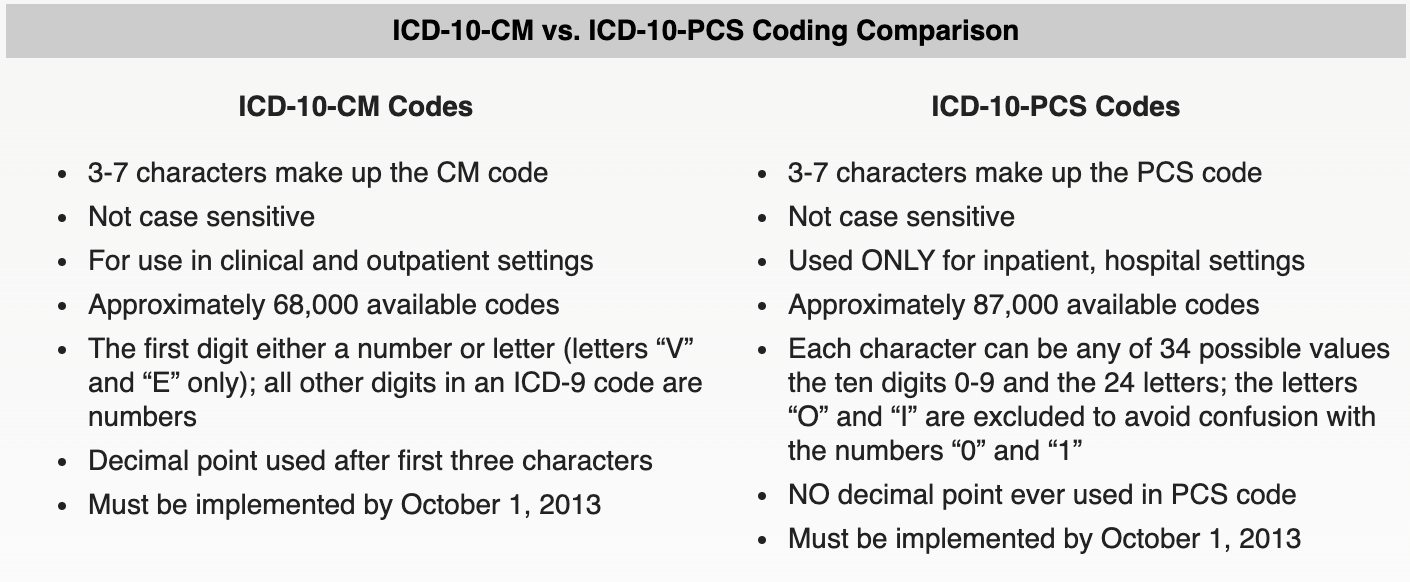

**Pretrained ICD-10 Models**

- `sbiobertresolve_icd10cm_augmented`
- `sbiobertresolve_icd10pcs`
- `sbiobertresolve_icd10cm_augmented_billable_hcc`
- `sbiobertresolve_icd10cm`
- `sbiobertresolve_icd10cm_slim_normalized`
- `sbiobertresolve_icd10cm_slim_billable_hcc`
- `sbertresolve_icd10cm_slim_billable_hcc_med`
- `sbiobertresolve_icd10cm_generalised`

### Creating ICD-10CM Pipeline

In [15]:
# Annotator that transforms a text column from dataframe into an Annotation ready for NLP
document_assembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

# Sentence Detector DL annotator, processes various sentences per line
sentenceDetectorDL = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare", "en", 'clinical/models') \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP
tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

# WordEmbeddingsModel pretrained "embeddings_clinical" includes a model of 1.7Gb that needs to be downloaded
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("word_embeddings")

# Named Entity Recognition for clinical concepts.
clinical_ner = MedicalNerModel.pretrained("ner_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "word_embeddings"]) \
    .setOutputCol("ner")

ner_converter_icd = NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")\
    .setWhiteList(['PROBLEM'])\
    .setPreservePosition(False)

c2doc = Chunk2Doc()\
    .setInputCols("ner_chunk")\
    .setOutputCol("ner_chunk_doc") 

sbert_embedder = BertSentenceEmbeddings.pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["ner_chunk_doc"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)
    
icd_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_augmented_billable_hcc","en", "clinical/models") \
    .setInputCols(["ner_chunk", "sentence_embeddings"]) \
    .setOutputCol("icd10cm_code")\
    .setDistanceFunction("EUCLIDEAN")
    

# Build up the pipeline
resolver_pipeline = Pipeline(
    stages = [
        document_assembler,
        sentenceDetectorDL,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter_icd,
        c2doc,
        sbert_embedder,
        icd_resolver
  ])


empty_data = spark.createDataFrame([['']]).toDF("text")

model = resolver_pipeline.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical download started this may take some time.
Approximate size to download 13.9 MB
[OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_icd10cm_augmented_billable_hcc download started this may take some time.
Approximate size to download 1.1 GB
[OK!]


**Create a SparkDataFrame with the content**

Now we will create a sample Spark dataframe with our clinical note example.

In this example we are working over a unique clinical note. In production environments a table with several of those clinical notes could be distributed in a cluster and be run in large scale systems.

In [16]:
clinical_note = (
    'A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years '
    'prior to presentation and subsequent type two diabetes mellitus, associated '
    'with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, '
    'presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting. '
    'Two weeks prior to presentation, she was treated with a five-day course of amoxicillin '
    'for a respiratory tract infection. She had been on dapagliflozin for six months '
    'at the time of presentation. Physical examination on presentation was significant for dry oral mucosa; '
    'significantly, her abdominal examination was benign with no tenderness or guarding. Pertinent '
    'laboratory findings on admission were: serum glucose 111 mg/dl, bicarbonate 18 mmol/l, anion gap 20, '
    'creatinine 0.4 mg/dL, triglycerides 508 mg/dL, total cholesterol 122 mg/dL, glycated hemoglobin (HbA1c) '
    '10%, and venous pH 7.27. Serum lipase was normal at 43 U/L. Serum acetone levels could not be assessed '
    'as blood samples kept hemolyzing due to significant lipemia. The patient was initially admitted for '
    'starvation ketosis, as she reported poor oral intake for three days prior to admission.')


data_ner = spark.createDataFrame([[clinical_note]]).toDF("text")

In [17]:
data_ner.show(truncate = 100)

+----------------------------------------------------------------------------------------------------+
|                                                                                                text|
+----------------------------------------------------------------------------------------------------+
|A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior ...|
+----------------------------------------------------------------------------------------------------+



In [18]:
icd10_result = model.transform(data_ner)

In [19]:
%time icd10_result.select("icd10cm_code.metadata").show(truncate=100)

+----------------------------------------------------------------------------------------------------+
|                                                                                            metadata|
+----------------------------------------------------------------------------------------------------+
|[{chunk -> 0, all_k_results -> O2441:::O2443:::Z8632:::Z875:::O2431:::O2411:::O244:::O241:::O2481...|
+----------------------------------------------------------------------------------------------------+

CPU times: user 93.7 ms, sys: 5.81 ms, total: 99.5 ms
Wall time: 17 s


In [20]:
%%time

res_pd = get_codes_from_df(icd10_result, 'ner_chunk', 'icd10cm_code', hcc=True)
res_pd.head(10)

CPU times: user 300 ms, sys: 35.3 ms, total: 335 ms
Wall time: 1min 5s


**The values in `billable`, `hcc_code` and `hcc_status` columns are seperated by || and we will change them to a list.**

In [21]:
res_pd["billable"] = res_pd["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,0]    
res_pd["hcc_status"] = res_pd["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,1]
res_pd["hcc_code"] = res_pd["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,2]

res_pd.drop("hcc_list", axis=1, inplace= True)

In [22]:
res_pd.head(15)

sent_id                              ner_chunk   entity icd10_code  \
0   0       gestational diabetes mellitus          PROBLEM  O2441       
1   0       subsequent type two diabetes mellitus  PROBLEM  O2411       
2   0       an acute hepatitis                     PROBLEM  B15         
3   0       obesity                                PROBLEM  E669        
4   0       a body mass index                      PROBLEM  Z6841       
5   0       polyuria                               PROBLEM  R35         
6   0       polydipsia                             PROBLEM  R631        
7   0       poor appetite                          PROBLEM  R630        
8   0       vomiting                               PROBLEM  R111        
9   1       a respiratory tract infection          PROBLEM  J988        
10  3       dry oral mucosa                        PROBLEM  K130        
11  3       tenderness                             PROBLEM  R52         
12  3       guarding                               PROBLEM  M6283       
13  6       hemolyzing                             PROBLEM  O046        
14  6       significant lipemia                    PROBLEM  E785        

                                                                                                                            all_codes  \
0   [O2441, O2443, Z8632, Z875, O2431, O2411, O244, O241, O2481]                                                                        
1   [O2411, E118, E11, E139, E119, E113, E1144, Z863, Z8639, E1132, E1143, E115]                                                        
2   [B15, K720, B179, B172, Z0389, B159, K752, K712, B199, B16, K701, B169]                                                             
3   [E669, E668, Z6841, Q130, E66, E6601, Z8639, E349, H3550, Z8349, Q5562]                                                             
4   [Z6841, E669, R229, Z681, R223, R221, Z68, R222, R220, R4189, M6258, P299, R1900, R898, M2170, R190, M2180]                         
5   [R35, R358, E232, R31, R350, R8299, N401, E723, O048, R300, R319, E7201, R809, E888, R808, N030, P960, R80, N026, B80]              
6   [R631, F6389, E232, F639, O40, G475, M7989, R632, R061, H538, I442, G479, G478, G471, Q308, I459, R002, R0681, G4754, R068, M353]   
7   [R630, P929, R438, R432, E86, R196, F520, Z724, R0689, Z7689, R531, R458, F508, R109, R4581]                                        
8   [R111, R11, R1110, G43A1, P921, P9209, G43A, R1113, R110]                                                                           
9   [J988, J069, A499, J22, J209, Z593, T17, J0410, Z1383, J189, P289, J399, J989]                                                      
10  [K130, L853, R682, J392, L678, M359, R238, R234, H041, K148, J3489, R195]                                                           
11  [R52, R51, M2556, L905, J348, R208, Z658, F602, O3689, M7960, R1082, M791, I899, R458, M2551, R4586, L298]                          
12  [M6283, Z9189, O987, H527, R298, Z710, F99, F340, T749, R54, R6889, R4589, Z789, R4689, R452, R442, Z748]                           
13  [O046, R718, R898, T8289, H448, D759, D758, D594, O036, R7989, R195, R31, D648, N029, R319]                                         
14  [E785, R798, Z8349, E756, R748, R898, J628, D7282, Z8639, E784, E1069, E7841, Z863, E786]                                           

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    resolutions  \
0   [gestational diabetes mellitus, postpartum gestational diabetes mellitus, history of gestational diabetes 

Lets apply some HTML formating by using `sparknlp_display` library to see the results of the pipeline in a nicer layout:

In [23]:
from sparknlp_display import EntityResolverVisualizer

icd10_lp = LightPipeline(model)

light_result = icd10_lp.fullAnnotate(clinical_note)

visualiser = EntityResolverVisualizer()

# Change color of an entity label
visualiser.set_label_colors({'PROBLEM':'#008080'})

visualiser.display(light_result[0], 'ner_chunk', 'icd10cm_code')

### ICD10CM with BertSentenceChunkEmbeddings

**BertSentenceChunkEmbeddings**

- This annotator let users to aggregate sentence embeddings and ner chunk embeddings to get more specific and accurate resolution codes. It works by averaging context and chunk embeddings to get contextual information. Input to this annotator is the context (sentence) and ner chunks, while the output is embedding for each chunk that can be fed to the resolver model. The `setChunkWeight` parameter can be used to control the influence of surrounding context.

- For more information and examples of `BertSentenceChunkEmbeddings` annotator, you can check here: 
[24.1.Improved_Entity_Resolution_with_SentenceChunkEmbeddings.ipynb](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/24.1.Improved_Entity_Resolution_with_SentenceChunkEmbeddings.ipynb)

Lets do the same process by using `BertSentenceEmbeddings` annotator and compare the results. We will create a new pipeline by using this annotator with SentenceEntityResolverModel.

In [24]:
#Get average sentence-chunk Bert embeddings
sentence_chunk_embeddings = BertSentenceChunkEmbeddings.pretrained("sbiobert_base_cased_mli", "en", "clinical/models")\
    .setInputCols(["sentence", "ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)\
    .setChunkWeight(0.5) #default : 0.5
    
icd_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_augmented_billable_hcc","en", "clinical/models") \
    .setInputCols(["ner_chunk", "sentence_embeddings"]) \
    .setOutputCol("icd10cm_code")\
    .setDistanceFunction("EUCLIDEAN")
  
resolver_pipeline_SCE = Pipeline(
    stages = [
        document_assembler,
        sentenceDetectorDL,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter_icd,
        sentence_chunk_embeddings,
        icd_resolver
  ])


empty_data = spark.createDataFrame([['']]).toDF("text")
model_SCE = resolver_pipeline_SCE.fit(empty_data)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_icd10cm_augmented_billable_hcc download started this may take some time.
Approximate size to download 1.1 GB
[OK!]


In [25]:
model.stages

[DocumentAssembler_0db21f9d610b,
 SentenceDetectorDLModel_6bafc4746ea5,
 REGEX_TOKENIZER_4d59ebbf3c66,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 MedicalNerModel_cd5ce67b529f,
 NerConverterInternal_668d98d3f95b,
 Chunk2Doc_ce1afc44017a,
 BERT_SENTENCE_EMBEDDINGS_0bee53f1b2cc,
 ENTITY_1868e4d7b1a3]

In [26]:
model_SCE.stages

[DocumentAssembler_0db21f9d610b,
 SentenceDetectorDLModel_6bafc4746ea5,
 REGEX_TOKENIZER_1b71f2129d97,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 MedicalNerModel_cd5ce67b529f,
 NerConverterInternal_668d98d3f95b,
 BERTSENTENCECHUNKEMBEDDINGS_f3be36320f33,
 ENTITY_1868e4d7b1a3]

In [27]:
icd10_result_SCE = model_SCE.transform(data_ner)

In [28]:
%%time

res_SCE_pd = get_codes_from_df(icd10_result_SCE, 'ner_chunk', 'icd10cm_code', hcc=True)

res_SCE_pd["billable"] = res_SCE_pd["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,0]    
res_SCE_pd["hcc_status"] = res_SCE_pd["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,1]
res_SCE_pd["hcc_code"] = res_SCE_pd["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,2]

res_SCE_pd.drop("hcc_list", axis=1, inplace= True)

CPU times: user 324 ms, sys: 27.9 ms, total: 352 ms
Wall time: 1min 6s


In [29]:
res_SCE_pd.head(15)

sent_id                              ner_chunk   entity icd10_code  \
0   0       gestational diabetes mellitus          PROBLEM  O244        
1   0       subsequent type two diabetes mellitus  PROBLEM  O2413       
2   0       an acute hepatitis                     PROBLEM  B169        
3   0       obesity                                PROBLEM  O9921       
4   0       a body mass index                      PROBLEM  E1300       
5   0       polyuria                               PROBLEM  R35         
6   0       polydipsia                             PROBLEM  F6389       
7   0       poor appetite                          PROBLEM  F500        
8   0       vomiting                               PROBLEM  R197        
9   1       a respiratory tract infection          PROBLEM  Z870        
10  3       dry oral mucosa                        PROBLEM  R238        
11  3       tenderness                             PROBLEM  R448        
12  3       guarding                               PROBLEM  Z653        
13  6       hemolyzing                             PROBLEM  O046        
14  6       significant lipemia                    PROBLEM  E755        

                                                                                                                   all_codes  \
0   [O244, O2443, O2441, O2442, O2413]                                                                                         
1   [O2413, E116, E1143, O2411, E1110, E110, O2412, E114, E1169, E111, O241, K318, E1133, O244, E112]                          
2   [B169, B159, B162, B179, B160, E8021, K712, O266, B181, F1098, B150]                                                       
3   [O9921, E233, E668, E349, O2600, E662, E669, E236, R7302, E6601, O99215, R730, N911]                                       
4   [E1300, O211, R730, E110, O9921, O2441, O992, R7302, P90, O998, N911, E0900, E090, E668, O99215, E662, E233, E111, R298]   
5   [R35, D595, O139, O122, D6869, O133, O1222, O132, O1225, O1223, O1220, O149, N020]                                         
6   [F6389, R631, E232, F639, G473, O9989, E870, A691, O40, G470, R060, E806, Z8742, D595, Z874, O997, R32, R0600]             
7   [F500, F508, F5001, K117, F502, R636, R630, E86, E161, F5089, E43, P05]                                                    
8   [R197, P783, R11, R1110, P9209, G43A, O21, R112, O210, T5090, G43A1]                                                       
9   [Z870, Z8709, J470, J988, A499, J22, Y839, Z593, J158, J156, A420, J202, B20, J40, O3689]                                  
10  [R238, K130, K148, J392, Z0189, R682, M359, N908, J3489, L853, R234]                                                       
11  [R448, R58, L2083, G9050, R200, R52, R6883, R1110, M779, R102, N941, P545, N908, R10819, G4040, R498, G588, R609, R292]    
12  [Z653, L2083, L744, R4589, R0689, R198, R468, K148, R0989, Z0100, R58, K130, R6889, R292, R238]                            
13  [O046, T8289, R898, D594, D749, R718, D759, R895, T8091, R58, D599, D592]                                                  
14  [E755, R898, D749, E754, D594, Z8343, T463X, E756, R748, T8289, R895, O046, D599, M793, O1420, O141]                       

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

Lets show the results on the raw text.

In [30]:
icd10_SCE_lp = LightPipeline(model_SCE)

light_result = icd10_SCE_lp.fullAnnotate(clinical_note)

visualiser = EntityResolverVisualizer()

# Change color of an entity label
visualiser.set_label_colors({'PROBLEM':'#008080'})

visualiser.display(light_result[0], 'ner_chunk', 'icd10cm_code')

Lets compare the results that we got from these two methods.

In [31]:
sentence_df = icd10_result.select(F.explode(F.arrays_zip('sentence.metadata', 'sentence.result')).alias("cols")) \
                          .select(F.expr("cols['0']['sentence']").alias("sent_id"),
                                  F.expr("cols['1']").alias("sentence_all")).toPandas()

comparison_df = pd.merge(res_pd.loc[:,'sent_id':'resolutions'],res_SCE_pd.loc[:,'sent_id':'resolutions'], on=['sent_id',"ner_chunk", "entity"], how='inner')
comparison_df.columns=['sent_id','ner_chunk', 'entity', 'icd10_code', 'all_codes', 'resolutions', 'icd10_code_SCE', 'all_codes_SCE', 'resolutions_SCE']

comparison_df = pd.merge(sentence_df, comparison_df,on="sent_id").drop('sent_id', axis=1)
comparison_df.head(15)

sentence_all  \
0   A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus, associated with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting.   
1   A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus, associated with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting.   
2   A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus, associated with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting.   
3   A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus, associated with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting.   
4   A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus, associated with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting.   
5   A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus, associated with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting.   
6   A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus, associated with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting.   
7   A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus, associated with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting.   
8   A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus, associated with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting.   
9   Two weeks prior to presentation, she was treated with a five-day course of amoxicillin for a respiratory tract infection.                                                                                                                                                                                                                         
10  Physical examination on presentation was significant for dry oral mucosa; significantly, her abdominal examination was benign with no tenderness or guarding.                                                                                                                                                                                     
11  Physical examination on presentation was significant for dry oral mucosa; significantly, her abdominal examination was benign with no tenderness or guarding.                                                  

## Sentence Entity Resolver (CPT)

The Current Procedural Terminology (CPT) code set is a medical code set maintained by the American Medical Association. The CPT code set describes medical, surgical, and diagnostic services and is designed to communicate uniform information about medical services and procedures among physicians, coders, patients, accreditation organizations, and payers for administrative, financial, and analytical purposes.

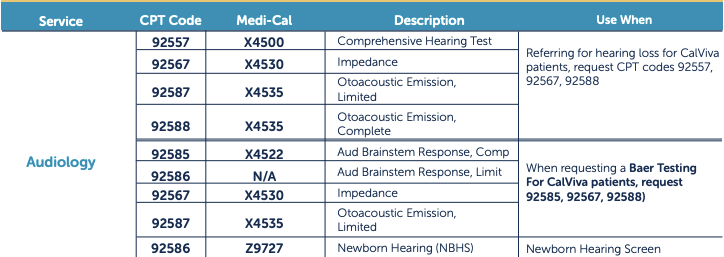

**Pretrained Models**

- `sbiobertresolve_cpt`
- `sbiobertresolve_cpt_procedures_augmented`
- `sbiobertresolve_cpt_augmented`
- `sbiobertresolve_cpt_procedures_measurements_augmented`

**We will create a pipeline to detect bodyparts and imaging tests entities and their relations. Then we will use these related chunks in CPT resolver model to get their CPT code.**

In [32]:
document_assembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetectorDL = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare", "en", 'clinical/models') \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("word_embeddings")


pos_tagger = PerceptronModel()\
    .pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token"])\
    .setOutputCol("pos_tags")
    
dependency_parser = DependencyParserModel()\
    .pretrained("dependency_conllu", "en")\
    .setInputCols(["sentence", "pos_tags", "token"])\
    .setOutputCol("dependencies")

# Named Entity Recognition for radiology reports.
clinical_ner = MedicalNerModel.pretrained("jsl_rd_ner_wip_greedy_clinical", "en", "clinical/models") \
   .setInputCols(["sentence", "token", "word_embeddings"]) \
   .setOutputCol("ner")

ner_chunker = NerConverter()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol("ner_chunk")

re_model = RelationExtractionModel()\
    .pretrained("re_bodypart_directions", "en", 'clinical/models')\
    .setInputCols(["word_embeddings", "pos_tags", "ner_chunk", "dependencies"])\
    .setOutputCol("relations")\
    .setRelationPairs(["imagingtest-bodypart", "bodypart-imagingtest"])\
    .setMaxSyntacticDistance(4)\
    .setPredictionThreshold(0.5)
      

# Build up the pipeline
relation_pipeline = Pipeline(
    stages = [
        document_assembler,
        sentenceDetectorDL,
        tokenizer,
        word_embeddings,
        pos_tagger,
        dependency_parser,
        clinical_ner,
        ner_chunker,
        re_model
        ])


empty_data = spark.createDataFrame([['']]).toDF("text")

rel_model = relation_pipeline.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[OK!]
jsl_rd_ner_wip_greedy_clinical download started this may take some time.
Approximate size to download 14.6 MB
[OK!]
re_bodypart_directions download started this may take some time.
Approximate size to download 9.2 MB
[OK!]


In [33]:
light_rel_model = LightPipeline(rel_model)

In [34]:
text="Left shin pain. I have ordered x-ray of the left fibula and knee today. The patient will return to the clinic in 3 weeks. He is to call me in the interim for any problems."
light_result = light_rel_model.fullAnnotate(text)

get_relations_df(light_result)

entity1 chunk1   entity2  chunk2 confidence
0  ImagingTest  x-ray  BodyPart  fibula  1.0      
1  ImagingTest  x-ray  BodyPart  knee    0.9458425

**Now we can use get CPT codes of these related chunks.**

In [35]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk")

sbert_embedder = BertSentenceEmbeddings\
    .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)
    
cpt_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_cpt_augmented","en", "clinical/models") \
    .setInputCols(["ner_chunk", "sentence_embeddings"]) \
    .setOutputCol("cpt_code")\
    .setDistanceFunction("EUCLIDEAN")


cpt_pipelineModel = PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        cpt_resolver])


cpt_lp = LightPipeline(cpt_pipelineModel)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_cpt_augmented download started this may take some time.
Approximate size to download 137.6 MB
[OK!]


In [36]:
text = 'fibula x-ray'

%time get_codes (cpt_lp, text, vocab='cpt_code')

CPU times: user 6.1 ms, sys: 1.84 ms, total: 7.94 ms
Wall time: 162 ms


chunks  begin  end   code  \
0  fibula x-ray  0      11   73590   

                                                         all_codes  \
0  [73590, 27676, 27455, 27712, 27457, 27707, 73550, 73090, 27635]   

                                                                                                                                                                                                      resolutions  \
0  [Tibia and fibula X-ray, Incision of fibula, Incision of fibula, Incision of fibula, Incision of fibula, Incision of fibula, Femur X-ray (procedure), Forearm X-ray, Excision of lesion of fibula (procedure)]   

                                                              all_distances  
0  [0.0895, 0.0970, 0.0970, 0.0970, 0.0970, 0.0970, 0.1360, 0.1364, 0.1474]

In [37]:
text = 'knee x-ray'

%time get_codes (cpt_lp, text, vocab='cpt_code')

CPU times: user 7.49 ms, sys: 3.42 ms, total: 10.9 ms
Wall time: 164 ms


chunks  begin  end   code  \
0  knee x-ray  0      9    73564   

                                                                                                              all_codes  \
0  [73564, 73562, 73580, 27486, 1010487, 27540, 27332, 27310, 27334, 27335, 27330, 73600, 73610, 1005006, 27447, 27446]   

                                                                                                                                                                                                                                                                                                                                                                   resolutions  \
0  [Knee X-ray, Knee X-ray, Knee arthrogram, Knee joint operations, Radiologic examination, knee, Operative procedure on knee, Arthrotomy of knee (procedure), Arthrotomy of knee (procedure), Arthrotomy of knee (procedure), Arthrotomy of knee (procedure), Arthrotomy of knee (procedure), Ankle X-ray, Ankle X-ray, Arthrotomy, knee, Knee replacement, Knee replacement]   

                                                                                                                      all_distances  
0  [0.0000, 0.0000, 0.0907, 0.1096, 0.1171, 0.1309, 0.1472, 0.1472, 0.1472, 0.1472, 0.1472, 0.1483, 0.1483, 0.1538, 0.1527, 0.1527]

In [38]:
text="TECHNIQUE IN DETAIL: After informed consent was obtained from the patient and his mother, the chest was scanned with portable ultrasound."
light_result = light_rel_model.fullAnnotate(text)

get_relations_df(light_result)

entity1 chunk1      entity2               chunk2 confidence
0  BodyPart  chest  ImagingTest  portable ultrasound  0.9999802

In [39]:
text = 'chest portable ultrasound'

%time get_codes (cpt_lp, text, vocab='cpt_code')

CPU times: user 4.94 ms, sys: 3.09 ms, total: 8.03 ms
Wall time: 159 ms


chunks  begin  end     code  \
0  chest portable ultrasound  0      24   1010771   

                                                                                all_codes  \
0  [1010771, 76512, 76510, 3320F, 76977, 76999, 76377, 45391, 76881, 31620, 3319F, 76882]   

                                                                                                                                                                                                                                                                                            resolutions  \
0  [Diagnostic Ultrasound Procedures of the Chest, A scan ultrasound, A scan ultrasound, USS - Ultrasound scan, USS - Ultrasound scan, USS - Ultrasound scan, USS - Ultrasound scan, USS - Ultrasound scan, USS - Ultrasound scan, USS - Ultrasound scan, USS - Ultrasound scan, USS - Ultrasound scan]   

                                                                                      all_distances  
0  [0.1269, 0.1563, 0.1563, 0.1582, 0.1582, 0.1582, 0.1582, 0.1582, 0.1582, 0.1582, 0.1582, 0.1582]

In [40]:
text="This 73 y/o patient had Brain CT on 1/12/95, with progressive memory and cognitive decline since 8/11/94."
light_result = light_rel_model.fullAnnotate(text)

get_relations_df(light_result)

entity1 chunk1      entity2 chunk2 confidence
0  BodyPart  Brain  ImagingTest  CT     0.9999999

In [41]:
text = 'brain CT'

%time get_codes (cpt_lp, text, vocab='cpt_code')

CPU times: user 6.59 ms, sys: 598 µs, total: 7.18 ms
Wall time: 156 ms


chunks  begin  end   code  \
0  brain CT  0      7    78607   

                                                                                                                 all_codes  \
0  [78607, 70559, 70551, 70552, 3111F, 70553, 3112F, 70558, 70557, 77371, 77372, 77432, 61516, 61530, 62148, 61566, 61314]   

                                                                                                                                                                                                                                                                                                           resolutions  \
0  [Cerebral scan, MRI of brain, MRI of brain, MRI of brain, MRI of brain, MRI of brain, MRI of brain, MRI of brain, MRI of brain, Procedure on brain, Procedure on brain, Procedure on brain, Craniotomy (procedure), Craniotomy (procedure), Craniotomy (procedure), Craniotomy (procedure), Craniotomy (procedure)]   

                                                                                                                              all_distances  
0  [0.1437, 0.1555, 0.1555, 0.1555, 0.1555, 0.1555, 0.1555, 0.1555, 0.1555, 0.1713, 0.1713, 0.1713, 0.1887, 0.1887, 0.1887, 0.1887, 0.1887]

## Sentence Entity Resolver (SNOMED)

SNOMED CT is one of a suite of designated standards for use in U.S. Federal Government systems for the electronic exchange of clinical health information and is also a required standard in interoperability specifications of the U.S. Healthcare Information Technology Standards Panel. The clinical terminology is owned and maintained by SNOMED International, a not-for-profit association. 

SNOMED CT:

- Is the most comprehensive and precise, multilingual health terminology in the world.
- Has been, and continues to be, developed collaboratively to ensure it meets the diverse needs and expectations of the worldwide medical profession.
- Assists with the electronic exchange of clinical health information.
- Can be mapped to other coding systems, such as ICD-9 and ICD-10, which helps facilitate semantic interoperability.
- Is accepted as a common global language for health terms in over 50 countries.
- Is a resource with extensive, scientifically validated clinical content

**Pretrained Models**

- `sbiobertresolve_snomed_auxConcepts_int`
- `sbiobertresolve_snomed_findings`
- `sbiobertresolve_snomed_findings_int`
- `sbiobertresolve_snomed_auxConcepts`
- `sbertresolve_snomed_bodyStructure_med`
- `sbiobertresolve_snomed_bodyStructure`
- `sbiobertresolve_snomed_findings_aux_concepts`
- `sbertresolve_snomed_conditions`

In [42]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk")

sbert_embedder = BertSentenceEmbeddings\
    .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)
    
snomed_ct_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_snomed_findings","en", "clinical/models") \
    .setInputCols(["ner_chunk", "sentence_embeddings"]) \
    .setOutputCol("snomed_code")\
    .setDistanceFunction("EUCLIDEAN")

snomed_pipelineModel = PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        snomed_ct_resolver])

snomed_lp = LightPipeline(snomed_pipelineModel)


sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_snomed_findings download started this may take some time.
Approximate size to download 1.3 GB
[OK!]


In [43]:
text = 'bladder cancer'

%time get_codes (snomed_lp, text, vocab='snomed_code')

CPU times: user 13.2 ms, sys: 2.02 ms, total: 15.2 ms
Wall time: 924 ms


chunks  begin  end       code  \
0  bladder cancer  0      13   399326009   

                                                                                                                                        all_codes  \
0  [399326009, 363455001, 425066001, 255108000, 269607003, 154540000, 425231005, 255110003, 393562002, 255109008, 255111004, 92546004, 254932004]   

                                                                                                                                                                                                                                                                                                                                                        resolutions  \
0  [bladder cancer, bladder cancer, invasive bladder cancer, carcinoma of bladder, carcinoma of bladder, carcinoma of bladder, superficial bladder cancer, adenocarcinoma of bladder, transitional cell carcinoma of bladder, transitional cell carcinoma of bladder, squamous cell carcinoma of bladder, cancer in situ of urinary bladder, tumor of bladder neck]   

                                                                                              all_distances  
0  [0.0000, 0.0000, 0.0539, 0.0666, 0.0666, 0.0666, 0.0809, 0.0881, 0.0880, 0.0880, 0.0913, 0.0978, 0.1080]

In [44]:
text = 'atrial fibrillation'

%time get_codes (snomed_lp, text, vocab='snomed_code')

CPU times: user 6.82 ms, sys: 6.37 ms, total: 13.2 ms
Wall time: 920 ms


chunks  begin  end      code  \
0  atrial fibrillation  0      18   49436004   

                                                                                                                                                  all_codes  \
0  [49436004, 155364009, 266306001, 282825002, 440059007, 426749004, 195081002, 762247006, 164889003, 300996004, 142049000, 440028005, 195080001, 81216002]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                 resolutions  \
0  [atrial fibrillation, atrial fibrillation, atrial fibrillation, intermittent atrial fibrillation, persistent atrial fibrillation, chronic atrial fibrillation, paroxysmal atrial fibrillation, preexcited atrial fibrillation, electrocardiographic atrial fibrillation, controlled atrial fibrillation (disorder), ecg: atrial fibrillation, permanent atrial fibrillation (disorder), atrial fibrillation and flutter, atrial fibrillation and flutter]   

                                                                                                      all_distances  
0  [0.0000, 0.0000, 0.0000, 0.0185, 0.0220, 0.0265, 0.0273, 0.0356, 0.0395, 0.0479, 0.0498, 0.0533, 0.0532, 0.0532]

## Sentence Entity Resolver (LOINC)

- Logical Observation Identifiers Names and Codes (LOINC) is a database and universal standard for identifying medical laboratory observations. First developed in 1994, it was created and is maintained by the Regenstrief Institute, a US nonprofit medical research organization. LOINC was created in response to the demand for an electronic database for clinical care and management and is publicly available at no cost.

- It is endorsed by the American Clinical Laboratory Association. Since its inception, the database has expanded to include not just medical laboratory code names but also nursing diagnosis, nursing interventions, outcomes classification, and patient care data sets.

- LOINC applies universal code names and identifiers to medical terminology related to electronic health records. The purpose is to assist in the electronic exchange and gathering of clinical results (such as laboratory tests, clinical observations, outcomes management and research). LOINC has two main parts: laboratory LOINC and clinical LOINC.

**Pretrained Models**

- `sbiobertresolve_loinc_cased`
- `sbluebertresolve_loinc_uncased`

In [45]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk")

sbert_embedder = BertSentenceEmbeddings\
    .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)
    
loinc_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_loinc", "en", "clinical/models") \
    .setInputCols(["ner_chunk", "sentence_embeddings"]) \
    .setOutputCol("loinc_code")\
    .setDistanceFunction("EUCLIDEAN")

loinc_pipelineModel = PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        loinc_resolver])

loinc_lp = LightPipeline(loinc_pipelineModel)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_loinc download started this may take some time.
Approximate size to download 212.6 MB
[OK!]


In [46]:
text = 'FLT3 gene mutation analysis'

%time get_codes (loinc_lp, text, vocab='loinc_code')

CPU times: user 7.7 ms, sys: 226 µs, total: 7.92 ms
Wall time: 227 ms


chunks  begin  end     code  \
0  FLT3 gene mutation analysis  0      26   54447-8   

                                                                                                                                                                                                                           all_codes  \
0  [54447-8, 47958-4, 21676-2, 75391-3, 38413-1, 53863-7, 92843-2, 57963-1, 49873-3, 58987-9, 53840-5, 81816-1, 22074-9, 21740-6, 34499-4, 41098-5, 49704-0, 46225-9, 38532-8, 71358-6, 81831-0, 53895-9, 41106-6, 35298-9, 49872-5]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            resolutions  \
0  [FLT3 gene targeted mutation analysis, FLT3 gene targeted mutation analysis, FGFR3 gene targeted mutation analysis, FGFR3 gene targeted mutation analysis, FGFR3 gene targeted mutation analysis, FLNA gene targeted mutation analysis, FLT3 gene.p.Asp835 mutations, FLCN gene targeted mutation analysis, POU3F4 gene targeted mutation analysis, ITGB3 gene targeted mutation analysis, TGFB3 gene targeted mutation analysis, OPA3 gene targeted mutation analysis, FGFR3 gene mutations tested for, TRAF3 gene targeted mutation analysis, GPC3 gene targeted mutation analysis, GPC3 gene targeted mutation analysis, SH3TC2 gene targeted mutation analysis, ABCA3 gene targeted mutation analysis, SPG3A gene targeted mutation analysis, GJB3 gene targeted mutation analysis, LAMB3 gene targeted mutation analysis, SH3BP2 gene targeted mutation analysis, FXN gene targeted mutation analysis, FXN gene targeted mutation analysis, FH gene targeted mutation analysis]   

                                                                                                                                                                                              all_distances  
0  [0.0354, 0.0354, 0.1021, 0.1021, 0.1021, 0.1111, 0.1155, 0.1135, 0.1258, 0.1249, 0.1285, 0.1255, 0.1316, 0.1287, 0.1328, 0.1328, 0.1346, 0.1315, 0.1351, 0.1352, 0.1339, 0.1390, 0.1347, 0.1347, 0.1318]

In [47]:
text = 'Hematocrit'

%time get_codes (loinc_lp, text, vocab='loinc_code')

CPU times: user 8.1 ms, sys: 2.76 ms, total: 10.9 ms
Wall time: 80.1 ms


chunks  begin  end     code  \
0  Hematocrit  0      9    11151-8   

                                                                                                                                                                                                                         all_codes  \
0  [11151-8, 42908-4, 11271-4, 30398-2, 48703-3, 13508-7, 71828-8, 55781-9, 17809-5, 4545-0, 71829-6, 47640-8, 71830-4, 11153-4, 31100-1, 4544-3, 71831-2, 70168-0, 32354-3, 62241-5, 70169-8, 71833-8, 43416-7, 41654-5, 41655-2]   

                                                                                                                                                                                                                                                                                                    resolutions  \
0  [Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit]   

                                                                                                                                                                                              all_distances  
0  [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]

## Sentence Entity Resolver (UMLS)

- Unified Medical Language System (UMLS) integrates and distributes key terminology, classification and coding standards, and associated resources to promote creation of more effective and interoperable biomedical information systems and services, including electronic health records.

- The UMLS, or Unified Medical Language System, is a set of files and software that brings together many health and biomedical vocabularies and standards to enable interoperability between computer systems.

- The Metathesaurus forms the base of the UMLS and comprises over 1 million biomedical concepts and 5 million concept names, all of which stem from the over 100 incorporated controlled vocabularies and classification systems. Some examples of the incorporated controlled vocabularies are CPT, ICD-10, MeSH, SNOMED CT, DSM-IV, LOINC, WHO Adverse Drug Reaction Terminology, UK Clinical Terms, RxNorm, Gene Ontology, and OMIM

**Pretrained Models**

- `sbiobertresolve_umls_findings`
- `sbiobertresolve_umls_major_concepts`
- `sbiobertresolve_umls_disease_syndrome`
- `sbiobertresolve_umls_clinical_drugs`

In [48]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk")

sbert_embedder = BertSentenceEmbeddings\
    .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)
    
umls_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_umls_major_concepts", "en", "clinical/models") \
    .setInputCols(["ner_chunk", "sentence_embeddings"]) \
    .setOutputCol("umls_code")\
    .setDistanceFunction("EUCLIDEAN")

umls_pipelineModel = PipelineModel(
      stages = [
          documentAssembler,
          sbert_embedder,
          umls_resolver])

umls_lp = LightPipeline(umls_pipelineModel)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_umls_major_concepts download started this may take some time.
Approximate size to download 761 MB
[OK!]


In [49]:
# Injuries & poisoning
text = 'food poisoning'

%time get_codes (umls_lp, text, vocab='umls_code')

CPU times: user 8.44 ms, sys: 529 µs, total: 8.97 ms
Wall time: 513 ms


chunks  begin  end      code  \
0  food poisoning  0      13   C0016479   

                                                                                                                            all_codes  \
0  [C0016479, C0349783, C0411266, C0178496, C0161615, C0275107, C1272775, C0161721, C0232071, C0749596, C1271087, C0274909, C0679360]   

                                                                                                                                                                                                                                                                                                                                                                                                            resolutions  \
0  [food poisoning, infectious food poisoning, chemical food poisoning (disorder), food poisoning bacterial, digestant poisoning, poisoning caused by ingestion of insect-infested food (disorder), burns food, toxic effect of noxious substance eaten as food (disorder), food aspiration, ingestion poisoning, suspected food poisoning (situation), toxic effect of food contaminant (disorder), foodborne illness]   

                                                                                              all_distances  
0  [0.0000, 0.0507, 0.0660, 0.0668, 0.0871, 0.0876, 0.0913, 0.0981, 0.0989, 0.1006, 0.1033, 0.1042, 0.1041]

In [50]:
# clinical findings
text = 'type two diabetes mellitus'

%time get_codes (umls_lp, text, vocab='umls_code')

CPU times: user 12.6 ms, sys: 1.38 ms, total: 14 ms
Wall time: 535 ms


chunks  begin  end      code  \
0  type two diabetes mellitus  0      25   C4014362   

                                                                                                                                                                                        all_codes  \
0  [C4014362, C3532488, C1320657, C1313937, C0455488, C2733146, C4017629, C3532489, C3275844, C0241863, C1261139, C0421248, C5195213, C1317301, C3278636, C2675471, C0235397, C4316344, C3872445]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                resolutions  \
0  [type 2 diabetes mellitus (t2d), history of diabetes mellitus type 2 (situation), diabete type, fh: diabetes mellitus, pre-existing diabetes mellitus, type 2 diabetes mellitus uncontrolled, diabetes mellitus, type ii, digenic, history of diabetes mellitus type i, diabetes mellitus, type ii, susceptibility to, diabetic, diabetic relative, insulin diabetic, increased risk of type 2 diabetes, diabetes status, neonatal insulin-dependent diabetes mellitus, microvascular complications of diabetes, susceptibility to, 2, diabetes mellitus precipitated, disorder of vision due to secondary diabetes mellitus (disorder), suspected glaucoma due to type 2 diabetes mellitus (situation)]   

                                                                                                                                              all_distances  
0  [0.0438, 0.0568, 0.0618, 0.0697, 0.0780, 0.0891, 0.0910, 0.0883, 0.0940, 0.0939, 0.1031, 0.1062, 0.1087, 0.1104, 0.1116, 0.1201, 0.1138, 0.1198, 0.1243]

## Sentence Entity Resolver (HPO)

The Human Phenotype Ontology (HPO) is a formal ontology of human phenotypes. Developed in collaboration with members of the Open Biomedical Ontologies Foundry, HPO currently contains over 13,000 terms and over 156,000 annotations to hereditary diseases. Data from Online Mendelian Inheritance in Man and medical literature were used to generate the terms currently in the HPO. The ontology contains over 50,000 annotations between phenotypes and hereditary disease.

Each term in the HPO describes a clinical abnormality. These may be general terms, such as Abnormal ear morphology or very specific ones such as Chorioretinal atrophy. Each term is also assigned to one of the five subontologies. The terms have a unique ID such as HP:0001140 and a label such as *Epibulbar dermoid*.

In [51]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk")

sbert_embedder = BertSentenceEmbeddings\
    .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)
    
hpo_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_HPO", "en", "clinical/models") \
    .setInputCols(["ner_chunk", "sentence_embeddings"]) \
    .setOutputCol("umls_code")\
    .setDistanceFunction("EUCLIDEAN")

hpo_pipelineModel = PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        hpo_resolver])

hpo_lp = LightPipeline(hpo_pipelineModel)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_HPO download started this may take some time.
Approximate size to download 97.9 MB
[OK!]


In [52]:
text = 'schizophrenia '

%time get_codes (hpo_lp, text, vocab='umls_code')

CPU times: user 26.9 ms, sys: 3.42 ms, total: 30.3 ms
Wall time: 394 ms


chunks  begin  end        code  \
0  schizophrenia   0      13   HP:0100753   

                                                                                                                                                                                                                                                                  all_codes  \
0  [HP:0100753, HP:0000709, HP:0007302, HP:0000708, HP:0000725, HP:0011511, HP:0012077, HP:0001345, HP:0030325, HP:0012075, HP:0000722, HP:0033512, HP:0012076, HP:0100923, HP:0002072, HP:0033715, HP:0010891, HP:0011626, HP:0100656, HP:0033516, HP:0008404, HP:0002269]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          resolutions  \
0  [schizophrenia, psychosis, bipolar disorder, psychiatric disorders, psychotic episodes, macular schisis, histrionic personality disorder, psychotic mentation, cervicomedullary schisis, personality disorder, obsessive compulsive disorder, stimulant dependence, borderline personality disorder, clavicular sclerosis, choreatic disease, mesial temporal sclerosis, scheuermann disease, scimitar syndrome, thoracoabdominal schisis, benzodiazepine dependence, onychodystrophy, migrational brain disorder]   

                                                                                                                                                                      all_distances  
0  [0.0000, 0.1172, 0.1488, 0.1599, 0.1877, 0.1898, 0.1923, 0.2033, 0.2163, 0.2113, 0.2166, 0.2257, 0.2202, 0.2345, 0.2431, 0.2389, 0.2497, 0.2438, 0.2578, 0.2483, 0.2604, 0.2455]

In [53]:
text = 'Abnormality of the upper limb'

%time get_codes (hpo_lp, text, vocab='umls_code')

CPU times: user 12 ms, sys: 3.55 ms, total: 15.5 ms
Wall time: 320 ms


chunks  begin  end        code  \
0  Abnormality of the upper limb  0      28   HP:0002817   

                                                                                                                                                                                                                                          all_codes  \
0  [HP:0002817, HP:0001454, HP:0009810, HP:0001446, HP:0100560, HP:0001457, HP:0040064, HP:0009808, HP:0040286, HP:0100022, HP:0002087, HP:0009127, HP:0000177, HP:0001999, HP:0011729, HP:0002813, HP:0001367, HP:0001155, HP:0000496, HP:0011297]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        resolutions  \
0  [abnormality of the upper limb, abnormality of the upper arm, abnormality of upper limb joint, abnormal upper limb muscles, upper limb asymmetry, abnormality of the musculature of the upper arm, abnormality of limbs, diaphyseal abnormality of the upper limbs, abnormality of axial muscles, abnormality of movement, abnormality of the upper respiratory tract, abnormal limb muscles, abnormality of upper lip, abnormal facial shape, abnormality of joint mobility, limb abnormality, abnormality of the joints, abnormality of the hand, abnormal eye movement, abnormality of digit]   

                                                                                                                                                      all_distances  
0  [0.0000, 0.0141, 0.0195, 0.0423, 0.0465, 0.0532, 0.0585, 0.0609, 0.0623, 0.0648, 0.0654, 0.0678, 0.0690, 0.0701, 0.0713, 0.0723, 0.0734, 0.0731, 0.0737, 0.0784]

In [54]:
text = 'Muscle haemorrhage'

%time get_codes (hpo_lp, text, vocab='umls_code')

CPU times: user 5.87 ms, sys: 1.75 ms, total: 7.62 ms
Wall time: 153 ms


chunks  begin  end        code  \
0  Muscle haemorrhage  0      17   HP:0040242   

                                                                                                                                                                  all_codes  \
0  [HP:0040242, HP:0012233, HP:0040223, HP:0025582, HP:0031611, HP:0001933, HP:0002239, HP:0031805, HP:0005261, HP:0011029, HP:0032990, HP:0025239, HP:0003713, HP:0031803]   

                                                                                                                                                                                                                                                                                                                          resolutions  \
0  [muscle haemorrhage, intramuscular hemorrhage, pulmonary haemorrhage, submacular haemorrhage, sub-ilm haemorrhage, subcutaneous haemorrhage, gi hemorrhage, intraretinal haemorrhage, joint haemorrhage, internal haemorrhage, localised pulmonary haemorrhage, subhyaloid haemorrhage, muscle fibre necrosis, fundus haemorrhage]   

                                                                                                      all_distances  
0  [0.0000, 0.0749, 0.1115, 0.1187, 0.1209, 0.1211, 0.1261, 0.1263, 0.1281, 0.1290, 0.1368, 0.1510, 0.1450, 0.1466]

## Router - Using Resolver Models Together

- Normally, when we need to use more than one sentence entity resolver models in the same pipeline, we used to hit `BertSentenceEmbeddings` annotator more than once given the number of different resolver models in the same pipeline. Now we are introducing a solution with the help of `Router` annotator that could allow us to feed all the NER chunks to `BertSentenceEmbeddings` at once and then route the output of Sentence Embeddings to different resolver models needed.

- In this example, lets use `sbiobertresolve_rxnorm` RxNorm model and `sbiobertresolve_icd10cm_slim_billable_hcc` ICD10CM-HCC models together. First we will get the `PROBLEM` entities form `ner_clinical` model and then get the `DRUG` entities from `ner_posology` model. Then we will merge them and use the `Chunk2Doc` annotator to create sentence chunks to populate Sentence Embeddings column. Then, we route the embeddings of `PROBLEM` entities to ICD10CM model and embeddings of `DRUG` entities to RxNorm model at the same time.

In [55]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetector()\
    .setInputCols("document")\
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols("sentence")\
    .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols("sentence", "token")\
    .setOutputCol("word_embeddings")

# to get PROBLEM entitis
clinical_ner = MedicalNerModel().pretrained("ner_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "word_embeddings"]) \
    .setOutputCol("clinical_ner")

clinical_ner_chunk = NerConverter()\
    .setInputCols("sentence","token","clinical_ner")\
    .setOutputCol("clinical_ner_chunk")\
    .setWhiteList(["PROBLEM"])

# to get DRUG entities 
posology_ner = MedicalNerModel().pretrained("ner_posology", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "word_embeddings"]) \
    .setOutputCol("posology_ner")

posology_ner_chunk = NerConverter()\
    .setInputCols("sentence","token","posology_ner")\
    .setOutputCol("posology_ner_chunk")\
    .setWhiteList(["DRUG"])

# merge the chunks into a single ner_chunk
chunk_merger = ChunkMergeApproach()\
    .setInputCols("clinical_ner_chunk","posology_ner_chunk")\
    .setOutputCol("final_ner_chunk")\
    .setMergeOverlapping(False)


# convert chunks to doc to get sentence embeddings of them
chunk2doc = Chunk2Doc().setInputCols("final_ner_chunk").setOutputCol("final_chunk_doc")


sbiobert_embeddings = BertSentenceEmbeddings.pretrained("sbiobert_base_cased_mli","en","clinical/models")\
    .setInputCols(["final_chunk_doc"])\
    .setOutputCol("sbert_embeddings")\
    .setCaseSensitive(False)

# filter PROBLEM entity embeddings
router_sentence_icd10 = Router() \
    .setInputCols("sbert_embeddings") \
    .setFilterFieldsElements(["PROBLEM"]) \
    .setOutputCol("problem_embeddings")

# filter DRUG entity embeddings
router_sentence_rxnorm = Router() \
    .setInputCols("sbert_embeddings") \
    .setFilterFieldsElements(["DRUG"]) \
    .setOutputCol("drug_embeddings")

# use problem_embeddings only
icd_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_slim_billable_hcc","en", "clinical/models") \
    .setInputCols(["clinical_ner_chunk", "problem_embeddings"]) \
    .setOutputCol("icd10cm_code")\
    .setDistanceFunction("EUCLIDEAN")


# use drug_embeddings only
rxnorm_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_rxnorm_augmented","en", "clinical/models") \
    .setInputCols(["posology_ner_chunk", "drug_embeddings"]) \
    .setOutputCol("rxnorm_code")\
    .setDistanceFunction("EUCLIDEAN")


pipeline = Pipeline(stages=[
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    clinical_ner,
    clinical_ner_chunk,
    posology_ner,
    posology_ner_chunk,
    chunk_merger,
    chunk2doc,
    sbiobert_embeddings,
    router_sentence_icd10,
    router_sentence_rxnorm,
    icd_resolver,
    rxnorm_resolver
])

empty_data = spark.createDataFrame([['']]).toDF("text")
model = pipeline.fit(empty_data)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical download started this may take some time.
Approximate size to download 13.9 MB
[OK!]
ner_posology download started this may take some time.
Approximate size to download 13.8 MB
[OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_icd10cm_slim_billable_hcc download started this may take some time.
Approximate size to download 856.5 MB
[OK!]
sbiobertresolve_rxnorm_augmented download started this may take some time.
Approximate size to download 930.9 MB
[OK!]


In [56]:
clinical_note = """The patient is a 41-year-old Vietnamese female with a cough that started last week. 
She has had right-sided chest pain radiating to her back with fever starting yesterday. 
She has a history of pericarditis in May 2006 and developed cough with right-sided chest pain. 
MEDICATIONS
1. Coumadin 1 mg daily. Last INR was on Tuesday, August 14, 2007, and her INR was 2.3.
2. Amiodarone 100 mg p.o. daily.
"""

In [57]:
df = spark.createDataFrame([[clinical_note]]).toDF("text")

result = model.transform(df)

In [58]:
icd10_result = get_codes_from_df(result, 'clinical_ner_chunk', 'icd10cm_code', hcc=True)

In [59]:
# extract HCC informationinto different columns

icd10_result["billable"] = icd10_result["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,0]    
icd10_result["hcc_status"] = icd10_result["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,1]
icd10_result["hcc_code"] = icd10_result["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,2]

icd10_result.drop("hcc_list", axis=1, inplace= True)

In [60]:
icd10_result.head(15)

sent_id               ner_chunk   entity icd10_code  \
0  0       a cough                 PROBLEM  R05         
1  1       right-sided chest pain  PROBLEM  R074        
2  1       fever                   PROBLEM  R509        
3  2       pericarditis            PROBLEM  I319        
4  2       cough                   PROBLEM  R05         
5  2       right-sided chest pain  PROBLEM  R074        

                                                                      all_codes  \
0  [R05, R0989]                                                                   
1  [R074, R0789, R072, R079, M79604, M79621, M79601, G8929, I998, R073, M25511]   
2  [R509, R508, A689, A68, A78, A771, J178, R502, A779, A790, B238]               
3  [I319, I301, I310, B3323, I311, I309, I30, T465X, I321, I313, I092]            
4  [R05, A37, R0989]                                                              
5  [R074, R0789, R072, R079, M79604, M79621, M79601, G8929, I998, R073, M25511]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         resolutions  \
0  [cough [Cough], respiratory tract congestion and cough (disorder) [Other specified symptoms and signs involving the circulatory and respiratory systems]]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
1  [right sided chest pain [Pain in throat and chest], right sided chest pain (finding) [Other chest pain], retrosternal chest pain [Precordial pain], acute chest pain [Chest pain, unspecified], right leg pain [Pain in right leg], right upper arm pain [Pain in right upper arm], chronic right arm pain [Pain in right arm], chronic right arm pain [Other chronic pain], right arm ischemic limb pain [Other disorder of circulatory system], cardiac chest pain [Pain in throat and chest], right shoulder pain [Pain in right shoulder]]                                                                                                                                      
2  [fever [Fever, unspecified], intermittent fever [Other specified fever], recurrent fever [Relapsing fever, unspecified], relapsing fevers [Relapsing fevers], acute q fever [Q fever], boutonneuse fever [Spotted fever due to Rickettsia conorii], query fever [Pneumonia in diseases classified elsewhere], drug induced fever [Drug induced fever], spotted fevers [Spotted fever, unspecified], wolhynian fever [Trench fever], fever associated with aids (disorder)]                                                                                                                                                                                                          
3  [pericarditis [Disease of pericardium, unspecified], infectious pericarditis [Infective pericarditis], adhesive pericarditis [Chronic adhesive pericarditis], viral pericarditis [Viral pericarditis], constrictive pericarditis [Chronic constrictive pericarditis], acute pericarditis [Acute pericarditis, unspecified], acute pericarditis [Acute pericarditis], drug

Now lets get RxNorm codes from our results.

In [65]:
rxnorm_result = get_codes_from_df(result, 'posology_ner_chunk', 'rxnorm_code', hcc=False)

rxnorm_result.head()

Py4JJavaError: ignored

### Using Router with Single NER Model

**If we want to get entities from only ONE NER model, it will be sufficient to feed the resolver models only with sentence embeddings from the `Router`. In the example below, we use `ner_clinical` model to get the `PROBLEM`,`TREATMENT` entities. Then we will feed the ICD10CM resolver model with the sentence embeddings of `PROBLEM` entities (`problem_embeddings`), and RxNorm resolver with `TREATMENT` entities (`drug_embeddings`) from the `Router`.**

In [62]:
ner = MedicalNerModel().pretrained("ner_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "word_embeddings"]) \
    .setOutputCol("ner")

ner_chunk = NerConverter()\
    .setInputCols("sentence","token","ner")\
    .setOutputCol("ner_chunk")\
    .setWhiteList(["PROBLEM","TREATMENT"])


chunk2doc = Chunk2Doc().setInputCols("ner_chunk").setOutputCol("jsl_chunk_doc")

sbiobert_embeddings = BertSentenceEmbeddings.pretrained("sbiobert_base_cased_mli","en","clinical/models")\
    .setInputCols(["jsl_chunk_doc"])\
    .setOutputCol("sbert_embeddings")\
    .setCaseSensitive(False)

router_sentence_icd10 = Router() \
    .setInputCols("sbert_embeddings") \
    .setFilterFieldsElements(["PROBLEM"]) \
    .setOutputCol("problem_embeddings")

router_sentence_rxnorm = Router() \
    .setInputCols("sbert_embeddings") \
    .setFilterFieldsElements(["TREATMENT"]) \
    .setOutputCol("drug_embeddings")


icd_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_slim_billable_hcc","en", "clinical/models") \
    .setInputCols(["problem_embeddings"]) \
    .setOutputCol("icd10cm_code")\
    .setDistanceFunction("EUCLIDEAN")


rxnorm_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_rxnorm_augmented","en", "clinical/models") \
    .setInputCols(["drug_embeddings"]) \
    .setOutputCol("rxnorm_code")\
    .setDistanceFunction("EUCLIDEAN")

resolver_pipeline = Pipeline(stages=[
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    ner,
    ner_chunk,
    chunk2doc,
    sbiobert_embeddings,
    router_sentence_icd10,
    router_sentence_rxnorm,
    icd_resolver,
    rxnorm_resolver
])

empty_data = spark.createDataFrame([['']]).toDF("text")
resolver_model = resolver_pipeline.fit(empty_data)

ner_clinical download started this may take some time.
Approximate size to download 13.9 MB
[OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_icd10cm_slim_billable_hcc download started this may take some time.
Approximate size to download 856.5 MB
[OK!]
sbiobertresolve_rxnorm_augmented download started this may take some time.
Approximate size to download 930.9 MB
[OK!]


In [63]:
single_ner_result = resolver_model.transform(df)

In [64]:
# explode problem_embeddings and icd10cm_code

single_icd_df = single_ner_result.select(F.explode(F.arrays_zip('problem_embeddings.metadata', 
                                                                'icd10cm_code.result', 
                                                                'icd10cm_code.metadata')).alias("cols")) \
                                .select(F.expr("cols['0']['token']").alias("ner_chunk"),
                                        F.expr("cols['0']['entity']").alias("entity"), 
                                        F.expr("cols['1']").alias("icd10_code"),
                                        F.expr("cols['2']['all_k_results']").alias("all_codes"),
                                        F.expr("cols['2']['all_k_resolutions']").alias("resolutions"),
                                        F.expr("cols['2']['all_k_aux_labels']").alias("hcc_list")).toPandas()

codes = []
resolutions = []
hcc_all = []

for code, resolution, hcc in zip(single_icd_df['all_codes'], single_icd_df['resolutions'], single_icd_df['hcc_list']):

    codes.append(code.split(':::'))
    resolutions.append(resolution.split(':::'))
    hcc_all.append(hcc.split(":::"))

single_icd_df['all_codes'] = codes  
single_icd_df['resolutions'] = resolutions
single_icd_df['hcc_list'] = hcc_all



# extract HCC informationinto different columns

single_icd_df["billable"] = single_icd_df["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,0]    
single_icd_df["hcc_status"] = single_icd_df["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,1]
single_icd_df["hcc_code"] = single_icd_df["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,2]

single_icd_df.drop("hcc_list", axis=1, inplace= True)

In [66]:
single_icd_df.head(15)

ner_chunk   entity icd10_code  \
0  a cough                 PROBLEM  R05         
1  right-sided chest pain  PROBLEM  R074        
2  fever                   PROBLEM  R509        
3  pericarditis            PROBLEM  I319        
4  cough                   PROBLEM  R05         
5  right-sided chest pain  PROBLEM  R074        

                                                                      all_codes  \
0  [R05, R0989]                                                                   
1  [R074, R0789, R072, R079, M79604, M79621, M79601, G8929, I998, R073, M25511]   
2  [R509, R508, A689, A68, A78, A771, J178, R502, A779, A790, B238]               
3  [I319, I301, I310, B3323, I311, I309, I30, T465X, I321, I313, I092]            
4  [R05, A37, R0989]                                                              
5  [R074, R0789, R072, R079, M79604, M79621, M79601, G8929, I998, R073, M25511]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         resolutions  \
0  [cough [Cough], respiratory tract congestion and cough (disorder) [Other specified symptoms and signs involving the circulatory and respiratory systems]]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
1  [right sided chest pain [Pain in throat and chest], right sided chest pain (finding) [Other chest pain], retrosternal chest pain [Precordial pain], acute chest pain [Chest pain, unspecified], right leg pain [Pain in right leg], right upper arm pain [Pain in right upper arm], chronic right arm pain [Pain in right arm], chronic right arm pain [Other chronic pain], right arm ischemic limb pain [Other disorder of circulatory system], cardiac chest pain [Pain in throat and chest], right shoulder pain [Pain in right shoulder]]                                                                                                                                      
2  [fever [Fever, unspecified], intermittent fever [Other specified fever], recurrent fever [Relapsing fever, unspecified], relapsing fevers [Relapsing fevers], acute q fever [Q fever], boutonneuse fever [Spotted fever due to Rickettsia conorii], query fever [Pneumonia in diseases classified elsewhere], drug induced fever [Drug induced fever], spotted fevers [Spotted fever, unspecified], wolhynian fever [Trench fever], fever associated with aids (disorder)]                                                                                                                                                                                                          
3  [pericarditis [Disease of pericardium, unspecified], infectious pericarditis [Infective pericarditis], adhesive pericarditis [Chronic adhesive pericarditis], viral pericarditis [Viral pericarditis], constrictive pericarditis [Chronic constrictive pericarditis], acute pericarditis [Acute pericarditis, unspecified], acute pericarditis [Acute pericarditis], drug-induced pericarditis [Poisoning by, adverse effect of and underdosing

In [67]:
single_rx_df = single_ner_result.select(F.explode(F.arrays_zip('drug_embeddings.metadata', 
                                                               'rxnorm_code.result', 
                                                               'rxnorm_code.metadata')).alias("cols")) \
                                .select(F.expr("cols['0']['token']").alias("ner_chunk"),
                                        F.expr("cols['0']['entity']").alias("entity"), 
                                        F.expr("cols['1']").alias("rxnorm_code"),
                                        F.expr("cols['2']['all_k_results']").alias("all_codes"),
                                        F.expr("cols['2']['all_k_resolutions']").alias("resolutions")).toPandas()

codes = []
resolutions = []

for code, resolution in zip(single_rx_df['all_codes'], single_rx_df['resolutions']):

    codes.append(code.split(':::'))
    resolutions.append(resolution.split(':::'))

single_rx_df['all_codes'] = codes  
single_rx_df['resolutions'] = resolutions

In [68]:
single_rx_df.head()

ner_chunk     entity rxnorm_code  \
0  Coumadin    TREATMENT  202421       
1  Amiodarone  TREATMENT  703          

                                                                                                                                                                        all_codes  \
0  [202421, 374998, 2898, 1855075, 128793, 1598, 152085, 218274, 21732, 375868, 1435932, 227590, 202392, 374560, 87866, 1603522, 5011, 54908]                                       
1  [703, 1663223, 1151983, 1151982, 203114, 377132, 1151981, 727379, 370568, 620, 1944369, 151347, 722, 370575, 1000082, 1000084, 5936, 17767, 2184119, 1153467, 1364410, 151908]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                         resolutions  
0  [Coumadin, coumarin Oral Tablet, coumarin, coumaran, Vicodin, dicumarol, Mycifradin, Medcodin, cresatin, cresatin Oral Solution, Reumacetin, Geocillin, Garamycin, ardeparin Injectable Solution, ardeparin, glabridin, gramicidin, policresulen]                                                                                                                                                                                                                                  
1  [amiodarone, amiodarone Injection, amiodarone Pill, amiodarone Oral Product, amiodarone hydrochloride, amiodarone Injectable Solution, amiodarone Injectable Product, amiodarone Prefilled Syringe, amiodarone Oral Tablet, amantadine, amantadine Extended Release Oral Capsule, Amsidine, amoxapine, amoxapine Oral Tablet, alcaftadine, alcaftadine Ophthalmic Solution, iodipamide, amlodipine, amlodipine Oral Suspension, adenosine Injectable Product, ioxapine, Iopidine]

## Healthcare Codes Mapping by Using Pretrained Pipelines

In Spark NLP, there are pretrained pipelines that can map these healthcare codes each other. Here is a list of these pipelines:

- `icd10cm_snomed_mapping` : ICD10 Codes to Snomed Codes
- `snomed_icd10cm_mapping` : Snomed Codes to ICD Codes
- `icd10cm_umls_mapping`   : ICD Codes to UMLS Codes
- `snomed_umls_mapping`    : Snomed Codes to UMLS Codes
- `rxnorm_umls_mapping`    : RxNorm Codes to UMLS Codes
- `mesh_umls_mapping`      : MeSH Codes to UMLS Codes
- `rxnorm_mesh_mapping`    : RxNorm Codes to MeSH Codes
- `icd10_icd9_mapping`     : ICD10 Codes to ICD9 Codes    

Lets show an example of ICD codes mapping to Snomed Codes to show how these pipelines work. 

In [69]:
from sparknlp.pretrained import PretrainedPipeline

In [70]:
icd10_snomed_pipeline = PretrainedPipeline("icd10cm_snomed_mapping", "en", "clinical/models")

icd10cm_snomed_mapping download started this may take some time.
Approx size to download 514.5 KB
[OK!]


In [71]:
icd10_snomed_pipeline.annotate('M89.50 I288 H16269')

{'icd10cm': ['M89.50', 'I288', 'H16269'],
 'snomed': ['733187009', '449433008', '51264003']}

|**ICD10CM** | **Details** | 
| ---------- | -----------:|
| M89.50 |  Osteolysis, unspecified site |
| I288 | Other diseases of pulmonary vessels |
| H16269 | Vernal keratoconjunctivitis, with limbar and corneal involvement, unspecified eye |

| **SNOMED** | **Details** |
| ---------- | -----------:|
| 733187009 | Osteolysis following surgical procedure on skeletal system |
| 449433008 | Diffuse stenosis of left pulmonary artery |
| 51264003 | Limbal AND/OR corneal involvement in vernal conjunctivitis |

Also if you want to see more examples, you can check [here](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/11.1.Healthcare_Code_Mapping.ipynb).



## Training and Finetuning Sentence Entity Resolver Model

For training Sentence Entity Resolver Model, you can check [this notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/13.Snomed_Entity_Resolver_Model_Training.ipynb).

For finetuning Sentence Entity Resolver Model, you can check [this notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/13.1.Finetuning_Sentence_Entity_Resolver_Model.ipynb).

## Sentence Entity Resolver Model - NER Model - Label whiteList Table

In the table below, you can find the Entity Resolver models, the most appropriate NER models and labels that can be used to get the most optimal results when using these models.

<table cellspacing="0" border="0" class="sortable"><thead><tr>
		<td style="border-top: 2px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="61" align="center" valign="middle"><b><font size="4" color="#000000">ENTITY RESOLVER MODEL</font></b></td>
		<td style="border-top: 2px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="center" valign="middle"><b><font size="4" color="#000000">SENTENCE EMBEDDINGS</font></b></td>
		<td style="border-top: 2px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="center" valign="middle"><b><font size="4" color="#000000">NER MODEL</font></b></td>
		<td style="border-top: 2px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="center" valign="middle"><b><font size="4" color="#000000">NER MODEL WHITELIST LABEL</font></b></td>
		<td style="border-top: 2px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="center" valign="middle"><b><font size="4" color="#000000">MERGE CHUNKS (ChunkMergeApproach)</font></b></td>
	</tr></thead>
	<colgroup width="378"></colgroup>
	<colgroup width="166"></colgroup>
	<colgroup width="240"></colgroup>
	<colgroup width="197"></colgroup>
	<colgroup width="161"></colgroup>
	<tbody>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/05/05/sbiobertresolve_HPO_en.html">sbiobertresolve_HPO</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_human_phenotype_gene_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">No need to set whiteList</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" rowspan="2" height="130" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/07/02/sbiobertresolve_cpt_procedures_measurements_augmented_en.html">sbiobertresolve_cpt_procedures_measurements_augmented</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" rowspan="2" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Procedure</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" rowspan="2" align="center" valign="middle"><font color="#000000">Merge ner_jsl and ner_measurements_clinical model chunks</font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_measurements_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Measurements</font></td>
		</tr>
	<tr>
		<td style="border-left: 2px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/05/30/sbiobertresolve_hcc_augmented_en.html">sbiobertresolve_hcc_augmented</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">PROBLEM</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/09/29/sbiobertresolve_hcpcs_en.html">sbiobertresolve_hcpcs</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Procedure</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/11/01/sbiobertresolve_icd10cm_augmented_billable_hcc_en.html">sbiobertresolve_icd10cm_augmented_billable_hcc</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">PROBLEM</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/09/29/sbiobertresolve_icd10cm_generalised_en.html">sbiobertresolve_icd10cm_generalised</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">PROBLEM</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2020/11/27/sbiobertresolve_icd10pcs_en.html">sbiobertresolve_icd10pcs</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Procedure</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/07/02/sbiobertresolve_icdo_base_en.html">sbiobertresolve_icdo_base</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Oncological</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="180" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/11/23/sbiobertresolve_loinc_augmented_en.html">sbiobertresolve_loinc_augmented</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Test<br>BMI<br>HDL<br>LDL<br>Medical_Device<br>Temperature<br>Total_Cholesterol<br>Triglycerides<br>Blood_Pressure</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/11/14/sbiobertresolve_mesh_en.html">sbiobertresolve_mesh</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">No need to set whiteList</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/05/16/sbiobertresolve_rxcui_en.html">sbiobertresolve_rxcui</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_posology</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">DRUG</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/11/09/sbiobertresolve_rxnorm_augmented_en.html">sbiobertresolve_rxnorm_augmented</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_posology</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">DRUG</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/08/12/sbiobertresolve_rxnorm_disposition_en.html">sbiobertresolve_rxnorm_disposition</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_posology</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">DRUG</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" rowspan="2" height="130" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/07/08/sbiobertresolve_snomed_bodyStructure_en.html">sbiobertresolve_snomed_bodyStructure</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" rowspan="2" align="center" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle">ner_jsl</td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle">Disease_Syndrome_Disorder<br>External_body_part_or_region</td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" rowspan="2" align="center" valign="middle"><font color="#000000">Merge ner_jsl and ner_anatomy_coarse model chunks</font></td>
	</tr>
	<tr>
		<td align="left" valign="middle"><font color="#000000">ner_anatomy_coarse</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle">No need to set whiteList</td>
		</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" rowspan="2" height="235" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/11/11/sbiobertresolve_snomed_procedures_measurements_en.html">sbiobertresolve_snomed_procedures_measurements</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" rowspan="2" align="center" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Procedure<br>Test<br>BMI<br>HDL<br>LDL<br>Temperature<br>Total_Cholesterol<br>Triglycerides<br>Blood_Pressure</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" rowspan="2" align="center" valign="middle"><font color="#000000">Merge ner_jsl and ner_measurements_clinical model chunks</font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_measurements_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Measurements</font></td>
		</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/06/15/sbiobertresolve_snomed_findings_en.html">sbiobertresolve_snomed_findings</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_clinical</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">No need to set whiteList</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="360" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/10/11/sbiobertresolve_umls_disease_syndrome_en.html">sbiobertresolve_umls_disease_syndrome</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Cerebrovascular_Disease<br>Communicable_Disease<br>Diabetes<br>Disease_Syndrome_Disorder<br>Heart_Disease<br>Hyperlipidemia<br>Hypertension<br>Injury_or_Poisoning<br>Kidney_Disease<br>Obesity<br>Oncological<br>Overweight<br>Psychological_Condition<br>Symptom<br>VS_Finding<br>ImagingFindings<br>EKG_Findings</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="65" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/10/11/sbiobertresolve_umls_clinical_drugs_en.html">sbiobertresolve_umls_clinical_drugs</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_posology</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">DRUG</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="117" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/10/03/sbiobertresolve_umls_major_concepts_en.html">sbiobertresolve_umls_major_concepts</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_jsl</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">Cerebrovascular_Disease<br>Communicable_Disease<br>Diabetes<br>Disease_Syndrome_Disorder<br>Heart_Disease<br>Hyperlipidemia<br>Hypertension<br>Injury_or_Poisoning<br>Kidney_Disease<br>Medical-Device<br>Obesity<br>Oncological<br>Overweight<br>Psychological_Condition<br>Symptom<br>VS_Finding<br>ImagingFindings<br>EKG_Findings</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 1px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
	<tr>
		<td style="border-top: 1px solid #000000; border-bottom: 2px solid #000000; border-left: 2px solid #000000; border-right: 1px solid #000000" height="88" align="left" valign="middle"><u><font color="#0563C1"><a href="https://nlp.johnsnowlabs.com/2021/11/27/sbiobertresolve_ndc_en.html">sbiobertresolve_ndc</a></font></u></td>
		<td style="border-top: 1px solid #000000; border-bottom: 2px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">sbiobert_base_cased_mli</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 2px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">ner_posology_greedy</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 2px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000">DRUG</font></td>
		<td style="border-top: 1px solid #000000; border-bottom: 2px solid #000000; border-left: 1px solid #000000; border-right: 1px solid #000000" align="left" valign="middle"><font color="#000000"><br></font></td>
	</tr>
</tbody><tfoot></tfoot></table>